In [3]:
import numpy as np
import pandas as pd

from pathlib import Path

In [5]:
camels_root = Path("S:\\CAMELS-CH\\CAMELS-CH\\camels_ch")
forcingOBS_root = camels_root / "timeseries" / "observation_based"
forcingSIM_root = camels_root / "timeseries" / "simulation_based"

In [11]:
forcingOBS_root

WindowsPath('S:/CAMELS-CH/CAMELS-CH/camels_ch/timeseries/observation_based')

In [6]:
files = list(forcingOBS_root.glob('*.'+"csv"))

In [7]:
basin = "2155"

In [8]:
files = list(forcingOBS_root.glob(f"**/CAMELS_CH_obs_based_{basin}*.csv"))
files

[WindowsPath('S:/CAMELS-CH/CAMELS-CH/camels_ch/timeseries/observation_based/CAMELS_CH_obs_based_2155.csv')]

In [9]:
df = pd.read_csv(files[0], header=0)
date = df.date

In [10]:
date

0        1981-01-01
1        1981-01-02
2        1981-01-03
3        1981-01-04
4        1981-01-05
            ...    
14605    2020-12-27
14606    2020-12-28
14607    2020-12-29
14608    2020-12-30
14609    2020-12-31
Name: date, Length: 14610, dtype: object

In [11]:
df.index = pd.to_datetime(date, format="%Y-%m-%d")

Read in the current dataset.py, so we can explore data generation and loading

In [12]:
import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset
from pathlib import Path
from bisect import bisect_right
from abc import ABCMeta, abstractmethod


class AbstractReader(metaclass=ABCMeta):
    """Abstract data reader.

    Its subclasses need to ensure conversion from raw data to pandas.DataFrame,
    and process invalid data item
    """

    @abstractmethod
    def _load_data(self, *args, **kwargs):
        """
        Subclasses must implement loading inputs and target data.
        """
        pass

    @abstractmethod
    def _process_invalid_data(self, *args, **kwargs):
        """
        Subclasses must implement how to process invalid data item.
        """
        pass

    @abstractmethod
    def get_df_x(self):
        """
        Subclasses must return inputs data with a form of pandas.DataFrame.
        """
        pass

    @abstractmethod
    def get_df_y(self):
        """
        Subclasses must return target data with a form of pandas.DataFrame.
        """
        pass


class AbstractStaticReader:
    """Abstract static data reader.

    1. Reads data from a static attributes file (.csv).
    2. Select used attributes and do normalization.
    3. Need to ensure conversion from static attributes to pandas.DataFrame.
    """

    @abstractmethod
    def get_df_static(self, basin):
        """
        Subclasses must return static data with a form of pandas.DataFrame for a specific basin
        """
        pass


class DaymetHydroReader(AbstractReader):
    camels_root = None  # needs to be set in class method "init_root"
    forcingOBS_root = None
    forcingSIM_root = None
    forcingOBS_cols = ["date", "discharge_vol(m3/s)", "discharge_spec(mm/d)", "waterlevel(m)",
                        "precipitation(mm/d)", "temperature_min(degC)", "temperature_mean(degC)", "temperature_max(degC)",
                        "rel_sun_dur(%)", "swe(mm)"]
    target = ["discharge_spec(mm/d)"]
    featuresOBS = ["precipitation(mm/d)", "temperature_min(degC)", "temperature_max(degC)", "swe(mm)"]
    selectionOBS = target + featuresOBS
    forcingSIM_cols = ["date", "discharge_vol_sim(m3/s)", "discharge_spec_sim(mm/d)", "precipitation_sim(mm/d)",
                        "temperature_sim(degC)", "radiation_sim(W/m2)", "sun_duration_sim(h)", "wind_sim(m/s)",
                        "rel_humidity_sim(%)", "pet_sim(mm/d)", "et_sim(mm/d)", "intercept_et_sim(mm/d)", "intercept_storage_sim(mm)"]
    featuresSIM = ["pet_sim(mm/d)"]
    features = featuresOBS + featuresSIM

    @classmethod
    def init_root(cls, camels_root):  # often be rewritten
        cls.camels_root = Path(camels_root)
        cls.forcingOBS_root = cls.camels_root / "timeseries" / "observation_based"
        cls.forcingSIM_root = cls.camels_root / "timeseries" / "simulation_based"

    def __init__(self, basin: str):
        self.basin = basin
        self.area = None
        df = self._load_data()
        df = self._process_invalid_data(df)
        self.df_x = df[self.features]  # Datetime as index
        self.df_y = df[self.target]  # Datetime as index

    def get_df_x(self):
        return self.df_x

    def get_df_y(self):
        return self.df_y

    def _load_data(self):
        df_forcingOBS = self._load_forcingOBS()
        df_forcingSIM = self._load_forcingSIM()
        df = pd.concat([df_forcingOBS["precipitation(mm/d)", "temperature_min(degC)", "temperature_max(degC)", "swe(mm)"], 
        df_forcingSIM["pet_sim(mm/d)"], 
        df_forcingOBS["discharge_spec(mm/d)"]], axis=1)

        return df

    # Loading observation based data
    def _load_forcingOBS(self):
        files = list(self.forcingOBS_root.glob(f"**/CAMELS_CH_obs_based_{self.basin}*.csv"))
        if len(files) == 0:
            raise RuntimeError(f"No forcing file found for Basin {self.basin}")
        elif len(files) >= 2:
            raise RuntimeError(f"Redundant forcing files found for Basin {self.basin}")
        else:
            file_path = files[0]

         # read-in data and get date
        df = pd.read_csv(file_path, header=0)
        self.features
        date = df.date
        df.index = pd.to_datetime(date, format="%Y-%m-%d")

        return df[self.selectionOBS]

    # Loading simulation based data
    def _load_forcingSIM(self):
        files = list(self.forcingSIM_root.glob(f"**/CAMELS_CH_sim_based_{self.basin}*.csv"))
        if len(files) == 0:
            raise RuntimeError(f"No discharge file found for Basin {self.basin}")
        elif len(files) >= 2:
            raise RuntimeError(f"Redundant discharge files found for Basin {self.basin}")
        else:
            file_path = files[0]

         # read-in data and get date
        df = pd.read_csv(file_path, header=0)
        date = df.date
        df.index = pd.to_datetime(date, format="%Y-%m-%d")

        return df[self.featuresSIM]

    # Processing invalid data
    def _process_invalid_data(self, df: pd.DataFrame):
        # Delete all row, where exits NaN (only discharge has NaN in this dataset)
        len_raw = len(df)
        df = df.dropna()
        len_drop_nan = len(df)
        if len_raw > len_drop_nan:
            print(f"Deleted {len_raw - len_drop_nan} records because of NaNs {self.basin}")

        # Deletes all records, where no discharge was measured (-999)
        df = df.drop((df[df["discharge_spec(mm/d)"] < 0]).index)
        len_drop_neg = len(df)
        if len_drop_nan > len_drop_neg:
            print(f"Deleted {len_drop_nan - len_drop_neg} records because of negative discharge {self.basin}")

        return df


class HydroReaderFactory:
    """
    Simple factory for producing HydroReader
    """

    @staticmethod
    def get_hydro_reader(camels_root, forcing_type, basin):
        if forcing_type == "daymet":
            DaymetHydroReader.init_root(camels_root)
            reader = DaymetHydroReader(basin)
        else:
            raise RuntimeError(f"No such hydro reader type: {forcing_type}")

        return reader


class CamelsDataset(Dataset):
    """CAMELS dataset working with subclasses of AbstractHydroReader.

    It works in a list way: the model trains, validates and tests with all of basins in attribute:basins_list.

    Attributes:
        camels_root: str
            The root of CAMELS dataset.
        basins_list: list of str
            A list contains all needed basins-ids (8-digit code).
        past_len: int
            Length of the past time steps for discharge data.
        pred_len: int
            Length of the predicting time steps for discharge data.
            And it is worth noting that the used length of meteorological data is (past_len + :pred_len).
        stage: str
            One of ['train', 'val', 'test'], decide whether calculating mean and std or not.
            Calculate mean and std in training stage.
        dates: List of pd.DateTimes
            Means the date range that is used, containing two elements, i.e, start date and end date.
        x_dict: dict as {basin: np.ndarray}
             Mapping a basin to its corresponding meteorological data.
        y_dict: dict as {basin: np.ndarray}
             Mapping a basin to its corresponding discharge data.
        length_ls: list of int
            Contains number of serialized sequences of each basin corresponding to basins_list.
        index_ls: list of int
            Created from length_ls, used in __getitem__ method.
        num_samples: int
            Number of serialized sequences of all basins.
        x_mean: numpy.ndarray
            Mean of input features derived from the training stage.
            Has to be provided for 'val' or 'test' stage.
            Can be retrieved if calling .get_means() on the data set.
        y_mean: numpy.ndarray
            Mean of output features derived from the training stage.
            Has to be provided for 'val' or 'test' stage.
            Can be retrieved if calling .get_means() on the data set.
        x_std: numpy.ndarray
            Std of input features derived from the training stage.
            Has to be provided for 'val' or 'test' stage.
            Can be retrieved if calling .get_stds() on the data set.
        y_std: numpy.ndarray
            Std of output features derived from the training stage.
            Has to be provided for 'val' or 'test' stage.
            Can be retrieved if calling .get_stds() on the data set.
    """

    def __init__(self, camels_root: str, forcing_type: str, basins_list: list, past_len: int, pred_len: int, stage: str,
                 dates: list, x_mean=None, y_mean=None, x_std=None, y_std=None, y_stds_dict=None):
        """Initialization

        x_mean, y_mean, x_std, y_std should be provided if stage != "train".
        """
        self.camels_root = camels_root
        self.basins_list = basins_list
        self.past_len = past_len
        self.pred_len = pred_len
        self.stage = stage
        self.dates = dates
        self.x_dict = dict()
        self.y_dict = dict()
        self.date_index_dict = dict()
        self.length_ls = list()

        if y_stds_dict is None:
            self.y_stds_dict = dict()
        else:
            self.y_stds_dict = y_stds_dict

        self._load_data(forcing_type)
        # Calculate mean and std
        if self.stage == 'train':
            self.x_mean, self.x_std = self.calc_mean_and_std(self.x_dict)
            self.y_mean, self.y_std = self.calc_mean_and_std(self.y_dict)
        else:
            self.x_mean = x_mean
            self.y_mean = y_mean
            self.x_std = x_std
            self.y_std = y_std
        self.normalize_data()

        self.num_samples = 0
        for item in self.length_ls:
            self.num_samples += item

        self.index_ls = [0]
        for i in range(len(self.length_ls)):
            v = self.index_ls[i] + self.length_ls[i]
            self.index_ls.append(v)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx: int):
        basin_idx = bisect_right(self.index_ls, idx) - 1
        local_idx = idx - self.index_ls[basin_idx]
        basin = self.basins_list[basin_idx]
        x_seq = self.x_dict[basin][local_idx: local_idx + self.past_len + self.pred_len, :]
        y_seq_past = self.y_dict[basin][local_idx: local_idx + self.past_len, :]
        y_seq_future = self.y_dict[basin][local_idx + self.past_len: local_idx + self.past_len + self.pred_len, :]

        return x_seq, y_seq_past, y_seq_future, self.y_stds_dict[basin]

    def _load_data(self, forcing_type):
        # Loading vanilla data
        basin_number = len(self.basins_list)
        for idx, basin in enumerate(self.basins_list):
            print(self.stage, f"{basin}: loading data %.4f" % (idx / basin_number))
            reader = HydroReaderFactory.get_hydro_reader(self.camels_root, forcing_type, basin)
            df_x = reader.get_df_x()
            df_y = reader.get_df_y()

            # Select date
            df_x = df_x[self.dates[0]:self.dates[1]]
            df_y = df_y[self.dates[0]:self.dates[1]]
            assert len(df_x) == len(df_y)
            self.date_index_dict[basin] = df_x.index

            # Select used features and discharge
            x = df_x.values.astype("float32")
            y = df_y.values.astype("float32")
            self.x_dict[basin] = x
            self.y_dict[basin] = y

            self.length_ls.append(len(x) - self.past_len - self.pred_len + 1)
            # Calculate mean and std in training stage
            if self.stage == 'train':
                self.y_stds_dict[basin] = y.std(axis=0).item()

    @staticmethod
    def calc_mean_and_std(data_dict):
        data_all = np.concatenate(list(data_dict.values()), axis=0)  # CAN NOT serializable
        nan_mean = np.nanmean(data_all, axis=0)
        nan_std = np.nanstd(data_all, axis=0)
        return nan_mean, nan_std

    def _local_normalization(self, feature: np.ndarray, variable: str) -> np.ndarray:
        if variable == 'inputs':
            feature = (feature - self.x_mean) / self.x_std
        elif variable == 'output':
            feature = (feature - self.y_mean) / self.y_std
        else:
            raise RuntimeError(f"Unknown variable type {variable}")
        return feature

    def normalize_data(self):
        # Normalize data
        for idx, basin in enumerate(self.basins_list):
            print(self.stage, "Normalizing %.4f" % (idx / len(self.basins_list)))
            x = self.x_dict[basin]
            y = self.y_dict[basin]
            # Normalize data
            x_norm = self._local_normalization(x, variable='inputs')
            y_norm = self._local_normalization(y, variable='output')
            self.x_dict[basin] = x_norm
            self.y_dict[basin] = y_norm

    def local_rescale(self, feature: np.ndarray, variable: str) -> np.ndarray:
        if variable == 'inputs':
            feature = feature * self.x_std + self.x_mean
        elif variable == 'output':
            feature = feature * self.y_std + self.y_mean
        else:
            raise RuntimeError(f"Unknown variable type {variable}")
        return feature

    def get_means(self):
        return self.x_mean, self.y_mean

    def get_stds(self):
        return self.x_std, self.y_std

    @classmethod
    def get_instance(cls, past_len: int, pred_len: int, stage: str, specific_cfg: dict,
                     x_mean=None, y_mean=None, x_std=None, y_std=None, y_stds_dict=None):
        final_data_path = specific_cfg["final_data_path"]
        camels_root = specific_cfg["camels_root"]
        basins_list = specific_cfg["basins_list"]
        forcing_type = specific_cfg["forcing_type"]
        start_date = specific_cfg["start_date"]
        end_date = specific_cfg["end_date"]
        if final_data_path is None:
            dates = [start_date, end_date]
            instance = cls(camels_root, forcing_type, basins_list, past_len, pred_len, stage,
                           dates, x_mean, y_mean, x_std, y_std, y_stds_dict)
            return instance
        else:
            if final_data_path.exists():
                instance = torch.load(final_data_path)
                return instance
            else:
                dates = [start_date, end_date]
                instance = cls(camels_root, forcing_type, basins_list, past_len, pred_len, stage,
                               dates, x_mean, y_mean, x_std, y_std, y_stds_dict)
                final_data_path.parent.mkdir(exist_ok=True, parents=True)
                torch.save(instance, final_data_path)
                return instance


class StaticReader(AbstractStaticReader):
    """Static hydrological data reader.

    Reads data from a selected norm static attributes file (.csv).
    Need to ensure conversion from static attributes to pandas.DataFrame.
    """

    def __init__(self, camels_root):
        self.camels_root = Path(camels_root)
        self.static_file_path = camels_root / "static_attributes" / "selected_norm_static_attributes.csv"
        self.df_static = pd.read_csv(self.static_file_path, header=0, dtype={"gauge_id": str}).set_index("gauge_id")
        self.df_static = self.df_static.astype("float32")

    def get_df_static(self, basin):
        return self.df_static.loc[[basin]].values


class CamelsDatasetWithStatic(CamelsDataset):
    """CAMELS dataset with static attributes injected into serialized sequences.

    Inherited from NullableCamelsDataset

    """

    def __init__(self, camels_root: str, forcing_type: str, basins_list: list, past_len: int, pred_len: int, stage: str,
                 dates: list, x_mean=None, y_mean=None, x_std=None, y_std=None, y_stds_dict=None):
        self.static_reader = StaticReader(camels_root)
        self.norm_static_fea = dict()
        super().__init__(camels_root, forcing_type, basins_list, past_len, pred_len, stage,
                         dates, x_mean, y_mean, x_std, y_std, y_stds_dict)

    def _load_data(self, forcing_type):
        # Loading vanilla data
        basin_number = len(self.basins_list)
        for idx, basin in enumerate(self.basins_list):
            print(self.stage, f"{basin}: loading data %.4f" % (idx / basin_number))
            reader = HydroReaderFactory.get_hydro_reader(self.camels_root, forcing_type, basin)
            df_x = reader.get_df_x()
            df_y = reader.get_df_y()

            # Select date
            df_x = df_x[self.dates[0]:self.dates[1]]
            df_y = df_y[self.dates[0]:self.dates[1]]
            assert len(df_x) == len(df_y)
            self.date_index_dict[basin] = df_x.index

            # Select used features and discharge
            x = df_x.values.astype("float32")
            y = df_y.values.astype("float32")

            self.x_dict[basin] = x
            self.y_dict[basin] = y

            self.length_ls.append(len(x) - self.past_len - self.pred_len + 1)
            # adding static attributes
            self.norm_static_fea[basin] = self.static_reader.get_df_static(basin)

            # Calculate mean and std in training stage
            if self.stage == 'train':
                self.y_stds_dict[basin] = y.std(axis=0).item()

    def normalize_data(self):
        # Normalize data
        for idx, basin in enumerate(self.basins_list):
            print(self.stage, "Normalizing %.4f" % (idx / len(self.basins_list)))
            x = self.x_dict[basin]
            y = self.y_dict[basin]
            # Normalize data
            x_norm = self._local_normalization(x, variable='inputs')
            y_norm = self._local_normalization(y, variable='output')
            norm_static_fea = self.norm_static_fea[basin].repeat(x_norm.shape[0], axis=0)
            x_norm_static = np.concatenate([x_norm, norm_static_fea], axis=1)
            self.x_dict[basin] = x_norm_static
            self.y_dict[basin] = y_norm

    def __getitem__(self, idx: int):
        basin_idx = bisect_right(self.index_ls, idx) - 1
        local_idx = idx - self.index_ls[basin_idx]
        basin = self.basins_list[basin_idx]
        x_seq = self.x_dict[basin][local_idx: local_idx + self.past_len + self.pred_len, :]
        y_seq_past = self.y_dict[basin][local_idx: local_idx + self.past_len, :]
        y_seq_future = self.y_dict[basin][local_idx + self.past_len: local_idx + self.past_len + self.pred_len, :]

        return x_seq, y_seq_past, y_seq_future, self.y_stds_dict[basin]



class CamelsDatasetLimited(CamelsDataset):
    def __getitem__(self, idx: int):
        basin_idx = bisect_right(self.index_ls, idx) - 1
        local_idx = idx - self.index_ls[basin_idx]
        basin = self.basins_list[basin_idx]
        x_seq = self.x_dict[basin][local_idx: local_idx + self.past_len, :]
        y_seq_past = self.y_dict[basin][local_idx: local_idx + self.past_len, :]
        y_seq_future = self.y_dict[basin][local_idx + self.past_len: local_idx + self.past_len + self.pred_len, :]

        return x_seq, y_seq_past, y_seq_future, self.y_stds_dict[basin]


class DatasetFactory:
    @staticmethod
    def get_dataset_type(use_future_fea, use_static):
        if (not use_future_fea) and use_static:
            raise RuntimeError("No implemented yet.")
        elif not use_future_fea:
            ds = CamelsDatasetLimited
        elif use_static:
            ds = CamelsDatasetWithStatic
        else:
            ds = CamelsDataset
        return ds


In [13]:
import os
os.getcwd()

's:\\tina\\AML\\P3'

In [14]:
# Set the new working directory
new_directory = 's:\\tina\\AML\\P3\\RR-Former'
os.chdir(new_directory)

In [15]:
os.getcwd()

's:\\tina\\AML\\P3\\RR-Former'

In [16]:
import pandas as pd
from pathlib import Path


class DatasetConfig:
    camels_root = Path("S:\\CAMELS-CH\\CAMELS-CH\\camels_ch")  # your CAMELS dataset root
    forcing_type = "daymet"  
    basin_mark = "170"  
    basins_file = f"data/{basin_mark}basins_list.txt"
    global_basins_list = pd.read_csv(basins_file, header=None, dtype=str)[0].values.tolist()

    # TODO: daymet date
    train_start = pd.to_datetime("1980-10-01", format="%Y-%m-%d")
    train_end = pd.to_datetime("1995-09-30", format="%Y-%m-%d")
    val_start = pd.to_datetime("1995-10-01", format="%Y-%m-%d")
    val_end = pd.to_datetime("2000-09-30", format="%Y-%m-%d")
    test_start = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
    test_end = pd.to_datetime("2014-09-30", format="%Y-%m-%d")

    dataset_info = f"{forcing_type}{basin_mark}_{train_start.year}~{train_end.year}#{val_start.year}~{val_end.year}#{test_start.year}~{test_end.year}"


In [17]:
camels_root= DatasetConfig.camels_root
basins_list=DatasetConfig.global_basins_list
forcing_type=DatasetConfig.forcing_type
start_date=DatasetConfig.train_start
end_date=DatasetConfig.train_end

In [18]:
global_basin=basins_list[0]

In [19]:
files = list(forcingOBS_root.glob(f"**/CAMELS_CH_obs_based_{basin}*.csv"))
if len(files) == 0:
    raise RuntimeError(f"No forcing file found for Basin {basin}")
elif len(files) >= 2:
    raise RuntimeError(f"Redundant forcing files found for Basin {basin}")
else:
    file_path = files[0]

# read-in data and get date
df = pd.read_csv(file_path, header=0)
date = df.date
df.index = pd.to_datetime(date, format="%Y-%m-%d")

In [20]:
df_forcingOBS = df

In [21]:
df_forcingOBS.columns

Index(['date', 'discharge_vol(m3/s)', 'discharge_spec(mm/d)', 'waterlevel(m)',
       'precipitation(mm/d)', 'temperature_min(degC)',
       'temperature_mean(degC)', 'temperature_max(degC)', 'rel_sun_dur(%)',
       'swe(mm)'],
      dtype='object')

In [22]:
files = list(forcingSIM_root.glob(f"**/CAMELS_CH_sim_based_{basin}*.csv"))
if len(files) == 0:
    raise RuntimeError(f"No discharge file found for Basin {basin}")
elif len(files) >= 2:
    raise RuntimeError(f"Redundant discharge files found for Basin {basin}")
else:
    file_path = files[0]

    # read-in data and get date
df = pd.read_csv(file_path, header=0)
date = df.date
df.index = pd.to_datetime(date, format="%Y-%m-%d")

In [23]:
df_forcingSIM = df

In [24]:
df_forcingSIM.columns

Index(['date', 'discharge_vol_sim(m3/s)', 'discharge_spec_sim(mm/d)',
       'precipitation_sim(mm/d)', 'temperature_sim(degC)',
       'radiation_sim(W/m2)', 'sun_duration_sim(h)', 'wind_sim(m/s)',
       'rel_humidity_sim(%)', 'pet_sim(mm/d)', 'et_sim(mm/d)',
       'intercept_et_sim(mm/d)', 'intercept_storage_sim(mm)'],
      dtype='object')

In [25]:
df = pd.concat([df_forcingOBS[["precipitation(mm/d)", "temperature_min(degC)", "temperature_max(degC)", "swe(mm)"]], 
df_forcingSIM["pet_sim(mm/d)"], 
df_forcingOBS["discharge_spec(mm/d)"]], axis=1)

In [27]:
camels_root = Path(camels_root)
static_file_path = camels_root / "static_attributes" / "selected_norm_static_attributes.csv"
static_file_path

WindowsPath('S:/CAMELS-CH/CAMELS-CH/camels_ch/static_attributes/selected_norm_static_attributes.csv')

In [28]:
df_static = pd.read_csv(static_file_path, sep=';',header=0, dtype={"gauge_id": str}).set_index("gauge_id")
df_static = df_static.astype("float32")

In [29]:
df_static = df_static.loc[[basin]].values

In [30]:
import torch

torch.cuda.is_available()

True

In [31]:
torch.cuda.device_count()

1

In [32]:
torch.cuda.current_device()

0

In [33]:
torch.cuda.device(0)

In [34]:
torch.cuda.get_device_name(0)

'NVIDIA T400'

In [35]:
torch.cuda.device(1)

In [37]:
import os
from pathlib import Path
import pickle

# Set the new working directory
wd = 's:\\tina\\AML\\P3\\RR-Former'
os.chdir(wd)
final_train_data_path = Path(wd) / "final_data"


In [38]:
fn = os.listdir(final_train_data_path)
fn

['daymet168@22_15+7[33+1]@1980-10-01~1995-09-30_serialized_train.pkl',
 'daymet168@22_15+7[33+1]@1995-10-01~2000-09-30_serialized_val.pkl',
 'daymet168@22_15+7[33+1]@2000-10-01~2014-09-30_serialized_test.pkl',
 'daymet218@22_15+7[33+1]@1980-10-01~1995-09-30_serialized_train.pkl',
 'daymet218@22_15+7[33+1]@1980-10-01~1995-09-30_serialized_train_global.pkl',
 'daymet218@22_15+7[33+1]@1995-10-01~2000-09-30_serialized_val.pkl',
 'daymet218@22_15+7[33+1]@2000-10-01~2014-09-30_serialized_test.pkl',
 'daymet218@22_15+7[33+1]@fold0@1980-10-01~1995-09-30_serialized_train.pkl',
 'daymet218@22_15+7[33+1]@fold0@1995-10-01~2000-09-30_serialized_val.pkl',
 'daymet218@22_15+7[33+1]@fold0@2000-10-01~2014-09-30_serialized_test.pkl',
 'daymet218@22_15+7[33+1]@fold1@1980-10-01~1995-09-30_serialized_train.pkl',
 'daymet218@22_15+7[33+1]@fold1@1995-10-01~2000-09-30_serialized_val.pkl',
 'daymet218@22_15+7[33+1]@fold1@2000-10-01~2014-09-30_serialized_test.pkl',
 'daymet218@22_15+7[33+1]@fold2@1980-10-01~199

In [39]:
fn[0]

'daymet168@22_15+7[33+1]@1980-10-01~1995-09-30_serialized_train.pkl'

In [42]:
# Select the file name with "fold0" and "test" in its string
selected_file = next((file for file in fn if "fold0" in file and "test" in file), None)
print(selected_file)

daymet218@22_15+7[33+1]@fold0@2000-10-01~2014-09-30_serialized_test.pkl


In [43]:
# Get the index of the file name with "fold0" and "test" in its string
selected_index = next((index for index, file in enumerate(fn) if "fold0" in file and "test" in file), None)
print(selected_index)

9


In [46]:
# List files in the directory retaining the full names
fn = [os.path.join(final_train_data_path, file) for file in os.listdir(final_train_data_path)]

# Print the list of files
print(fn)

['s:\\tina\\AML\\P3\\RR-Former\\final_data\\daymet168@22_15+7[33+1]@1980-10-01~1995-09-30_serialized_train.pkl', 's:\\tina\\AML\\P3\\RR-Former\\final_data\\daymet168@22_15+7[33+1]@1995-10-01~2000-09-30_serialized_val.pkl', 's:\\tina\\AML\\P3\\RR-Former\\final_data\\daymet168@22_15+7[33+1]@2000-10-01~2014-09-30_serialized_test.pkl', 's:\\tina\\AML\\P3\\RR-Former\\final_data\\daymet218@22_15+7[33+1]@1980-10-01~1995-09-30_serialized_train.pkl', 's:\\tina\\AML\\P3\\RR-Former\\final_data\\daymet218@22_15+7[33+1]@1980-10-01~1995-09-30_serialized_train_global.pkl', 's:\\tina\\AML\\P3\\RR-Former\\final_data\\daymet218@22_15+7[33+1]@1995-10-01~2000-09-30_serialized_val.pkl', 's:\\tina\\AML\\P3\\RR-Former\\final_data\\daymet218@22_15+7[33+1]@2000-10-01~2014-09-30_serialized_test.pkl', 's:\\tina\\AML\\P3\\RR-Former\\final_data\\daymet218@22_15+7[33+1]@fold0@1980-10-01~1995-09-30_serialized_train.pkl', 's:\\tina\\AML\\P3\\RR-Former\\final_data\\daymet218@22_15+7[33+1]@fold0@1995-10-01~2000-09-30_s

In [47]:
import torch
#serialized_data = torch.load(fn[0])
serialized_data = torch.load(fn[selected_index])

In [48]:
print(repr(serialized_data))

In [49]:
# 1. Print the Type
print("Type of serialized data:", type(serialized_data))

Type of serialized data: <class 'data.dataset.CamelsDatasetWithStatic'>


In [50]:
dir(serialized_data)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 '_load_data',
 '_local_normalization',
 'basins_list',
 'calc_mean_and_std',
 'camels_root',
 'date_index_dict',
 'dates',
 'get_instance',
 'get_means',
 'get_stds',
 'index_ls',
 'length_ls',
 'local_rescale',
 'norm_static_fea',
 'normalize_data',
 'num_samples',
 'past_len',
 'pred_len',
 'stage',
 'static_reader',
 'x_dict',
 'x_mean',
 'x_std',
 'y_dict',
 'y_mean',
 'y_std',
 'y_stds_dict']

In [29]:
serialized_valdata = torch.load(fn[1])

In [51]:
import sys

# Size of the serialized data
serialized_data_size = sys.getsizeof(serialized_data)
print("Size of serialized data:", serialized_data_size, "bytes")

# Size of each attribute
for attr_name in dir(serialized_data):
    attr = getattr(serialized_data, attr_name)
    attr_size = sys.getsizeof(attr)
    print(f"Size of attribute {attr_name}: {attr_size} bytes")

Size of serialized data: 48 bytes
Size of attribute __add__: 64 bytes
Size of attribute __annotations__: 64 bytes
Size of attribute __class__: 1072 bytes
Size of attribute __class_getitem__: 64 bytes
Size of attribute __delattr__: 48 bytes
Size of attribute __dict__: 640 bytes
Size of attribute __dir__: 72 bytes
Size of attribute __doc__: 170 bytes
Size of attribute __eq__: 48 bytes
Size of attribute __format__: 72 bytes
Size of attribute __ge__: 48 bytes
Size of attribute __getattribute__: 48 bytes
Size of attribute __getitem__: 64 bytes
Size of attribute __gt__: 48 bytes
Size of attribute __hash__: 48 bytes
Size of attribute __init__: 64 bytes
Size of attribute __init_subclass__: 64 bytes
Size of attribute __le__: 48 bytes
Size of attribute __len__: 64 bytes
Size of attribute __lt__: 48 bytes
Size of attribute __module__: 61 bytes
Size of attribute __ne__: 48 bytes
Size of attribute __new__: 72 bytes
Size of attribute __orig_bases__: 48 bytes
Size of attribute __parameters__: 40 byte

In [52]:
# Number of attributes in the serialized data
num_attributes_serialized_data = len(dir(serialized_data))
print("Number of attributes in serialized data:", num_attributes_serialized_data)

# Number of attributes for each attribute
for attr_name in dir(serialized_data):
    attr = getattr(serialized_data, attr_name)
    if hasattr(attr, '__dict__'):
        num_attributes_attr = len(vars(attr))
        print(f"Number of attributes in {attr_name}: {num_attributes_attr}")
    else:
        print(f"{attr_name} does not have __dict__ attribute")

Number of attributes in serialized data: 62
Number of attributes in __add__: 0
__annotations__ does not have __dict__ attribute
Number of attributes in __class__: 7
Number of attributes in __class_getitem__: 1
__delattr__ does not have __dict__ attribute
__dict__ does not have __dict__ attribute
__dir__ does not have __dict__ attribute
__doc__ does not have __dict__ attribute
__eq__ does not have __dict__ attribute
__format__ does not have __dict__ attribute
__ge__ does not have __dict__ attribute
__getattribute__ does not have __dict__ attribute
Number of attributes in __getitem__: 0
__gt__ does not have __dict__ attribute
__hash__ does not have __dict__ attribute
Number of attributes in __init__: 0
Number of attributes in __init_subclass__: 0
__le__ does not have __dict__ attribute
Number of attributes in __len__: 0
__lt__ does not have __dict__ attribute
__module__ does not have __dict__ attribute
__ne__ does not have __dict__ attribute
__new__ does not have __dict__ attribute
__ori

In [53]:
vars(serialized_data)

{'static_reader': <data.dataset.StaticReader at 0x172e25f35e0>,
 'norm_static_fea': {'2018': array([[ 0.42829075, -0.07624196, -0.45100248,  0.52214175, -0.24223046,
          -1.4880021 , -0.54475653, -1.2472316 , -0.98779714, -0.13769124,
           0.21601516,  1.4492438 ,  0.14714745,  0.19999588, -0.03824982,
          -0.33399656,  0.05038052,  2.37899   , -0.02270718,  0.12078433,
           0.54206574, -0.30084977,  0.5020043 ,  0.16692972, -0.16845694,
          -0.15300731, -0.07209807, -0.09773707,  0.51299006]],
        dtype=float32),
  '2020': array([[ 0.6863314 ,  0.8579617 , -0.02993102,  1.1308858 ,  0.03986064,
           1.3989376 ,  3.1377668 ,  1.1984773 ,  1.5999058 ,  0.54738045,
           1.3942794 ,  0.42666116, -0.7322544 ,  1.1629453 , -0.5580601 ,
           0.23433165,  0.3088668 , -0.28900853, -0.3313654 , -0.8926205 ,
           0.9352138 , -0.39828393, -1.2410002 ,  1.083749  , -1.0403112 ,
          -1.0626513 , -0.6411183 , -0.7326626 ,  0.71243364]],

In [54]:
# Count the total number of attributes in the serialized data
total_attributes = len(vars(serialized_data))

# Print the total number of attributes
print("Total number of attributes:", total_attributes)

Total number of attributes: 19


In [57]:
# Access the desired attribute directly
desired_attribute = getattr(serialized_data, 'basins_list', None)

print(desired_attribute)

['2018', '2020', '2033', '2053', '2084', '2086', '2087', '2106', '2159', '2160', '2167', '2185', '2199', '2203', '2232', '2247', '2270', '2288', '2303', '2319', '2346', '2372', '2374', '2403', '2410', '2416', '2419', '2426', '2471', '2480', '2603', '2608', '3033', '4002', '4004', '4006', '4012', '4017', '4025', '4026', '5003', '5011', '5019', '5031']


In [58]:
len(desired_attribute)

44

In [68]:
import pickle
import os

# Define the path to the serialized data files
final_data_path = final_train_data_path
folds = [f'fold{i}' for i in range(5)] #we used 5 folds
data_types = ['train', 'val', 'test']

# Define the full path to the output file
output_file_path = os.path.join(wd, 'folds_data_summary.txt')

# Open a text file to save the results
with open(output_file_path, 'w') as output_file:
    for fold in folds:
        for data_type in data_types:
            selected_index = next((index for index, file in enumerate(fn) if fold in file and data_type in file), None)
            file_path = fn[selected_index] if selected_index is not None else None
            print(f"Processing {file_path}")
            try:
                # Load the serialized data
                with open(file_path, 'rb') as file:
                    #serialized_data = pickle.load(file)
                    serialized_data = torch.load(file)
                
                # Extract the basins list and the length of the serialized data
                basins_list = getattr(serialized_data, 'basins_list', None)
                data_length = len(basins_list)
                
                # Write the results to the text file
                output_file.write(f"{fold} {data_type} basins: {basins_list}\n")
                output_file.write(f"{fold} {data_type} length: {data_length}\n")

                # If the data_type is 'test', write the basins list to a separate file
                if data_type == 'test':
                    test_basins_file_path = os.path.join(wd,"data", f"{fold}_{data_length}testbasins_list.txt")
                    with open(test_basins_file_path, 'w') as test_basins_file:
                        for basin in basins_list:
                            test_basins_file.write(f"{basin}\n")

            except FileNotFoundError:
                output_file.write(f"{file_path} not found.\n")
            except Exception as e:
                output_file.write(f"Error processing {file_path}: {e}\n")

Processing s:\tina\AML\P3\RR-Former\final_data\daymet218@22_15+7[33+1]@fold0@1980-10-01~1995-09-30_serialized_train.pkl
Processing s:\tina\AML\P3\RR-Former\final_data\daymet218@22_15+7[33+1]@fold0@1995-10-01~2000-09-30_serialized_val.pkl
Processing s:\tina\AML\P3\RR-Former\final_data\daymet218@22_15+7[33+1]@fold0@2000-10-01~2014-09-30_serialized_test.pkl
Processing s:\tina\AML\P3\RR-Former\final_data\daymet218@22_15+7[33+1]@fold1@1980-10-01~1995-09-30_serialized_train.pkl
Processing s:\tina\AML\P3\RR-Former\final_data\daymet218@22_15+7[33+1]@fold1@1995-10-01~2000-09-30_serialized_val.pkl
Processing s:\tina\AML\P3\RR-Former\final_data\daymet218@22_15+7[33+1]@fold1@2000-10-01~2014-09-30_serialized_test.pkl
Processing s:\tina\AML\P3\RR-Former\final_data\daymet218@22_15+7[33+1]@fold2@1980-10-01~1995-09-30_serialized_train.pkl
Processing s:\tina\AML\P3\RR-Former\final_data\daymet218@22_15+7[33+1]@fold2@1995-10-01~2000-09-30_serialized_val.pkl
Processing s:\tina\AML\P3\RR-Former\final_data\d

In [59]:
import pickle
from data.dataset import CamelsDataset, CamelsDatasetWithStatic  # Import necessary classes

# Define the file path where the serialized data is stored
#serialized_data_path = "path/to/serialized_data.pkl"  # Replace with the actual file path

# Load serialized data from file
with open(fn[0], 'rb') as f:
    serialized_data = pickle.load(f)

# Deserialize the data based on the dataset type
if isinstance(serialized_data, CamelsDataset):
    dataset = serialized_data  # No additional deserialization needed
elif isinstance(serialized_data, CamelsDatasetWithStatic):
    # If deserialized data is of type CamelsDatasetWithStatic, ensure the necessary classes are imported
    dataset = CamelsDatasetWithStatic(
        camels_root=serialized_data.camels_root,
        forcing_type=serialized_data.forcing_type,
        basins_list=serialized_data.basins_list,
        past_len=serialized_data.past_len,
        pred_len=serialized_data.pred_len,
        stage=serialized_data.stage,
        dates=serialized_data.dates,
        x_mean=serialized_data.x_mean,
        y_mean=serialized_data.y_mean,
        x_std=serialized_data.x_std,
        y_std=serialized_data.y_std,
        y_stds_dict=serialized_data.y_stds_dict
    )
else:
    raise ValueError("Unsupported dataset type")

# Now you can use the deserialized dataset object as needed
print(dataset)

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [12]:
import pandas as pd
data = pd.read_pickle(fn[0])

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

This is how data get loaded in the code

In [ ]:
    # Training data
    ds_train = DS.get_instance(past_len, pred_len, "train", specific_cfg=pre_train_config)
    train_loader = DataLoader(ds_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)

Show we make a new class for performing the stratified kefold splitting?

In [7]:
import numpy as np

class YourClassNameHere:
    def __init__(self, num_cv_folds, fold_nr, rs=None):
        self.num_cv_folds = num_cv_folds
        self.fold_nr = fold_nr
        self.rs = np.random.RandomState() if rs is None else rs

    def split_basins_stratified(self, basins, folds=None):
        if self.fold_nr not in range(self.num_cv_folds):
            raise ValueError(f'\'fold_nr\' must be in range [0, {self.num_cv_folds-1}], is {self.fold_nr}.')

        if folds is not None:
            # Ensure folds and basins have the same length
            if len(folds) != len(basins):
                raise ValueError("The length of 'folds' must match the length of 'basins'.")
            
            # Create groups based on folds
            groups = {fold: [] for fold in range(self.num_cv_folds)}
            for basin, fold in zip(basins, folds):
                groups[fold].append(basin)
            groups = [groups[fold] for fold in range(self.num_cv_folds)]
        else:
            # Random split as fallback
            basins = list(self.rs.permutation(basins))
            groups = np.array_split(basins, self.num_cv_folds)

        folds_set = set(range(self.num_cv_folds))
        valid_folds = {self.fold_nr % self.num_cv_folds}
        test_folds = {(self.fold_nr + 1) % self.num_cv_folds}
        train_folds = folds_set - valid_folds - test_folds

        train_basins, valid_basins, test_basins = [], [], []
        for group_i, group in enumerate(groups):
            if group_i in train_folds:
                train_basins.extend(group)
            if group_i in valid_folds:
                valid_basins.extend(group)
            if group_i in test_folds:
                test_basins.extend(group)

        return train_basins, valid_basins, test_basins

Play around with dummy example of stratified fold

In [8]:
import numpy as np

basins = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6']
folds = [0, 1, 2, 0, 1, 2]  # Example fold numbers for 3-fold cross-validation

# Assuming your class has been defined as above
num_cv_folds = 3
fold_nr = 0  # The fold to use as validation

splitter = YourClassNameHere(num_cv_folds, fold_nr)
train_basins, valid_basins, test_basins = splitter.split_basins_stratified(basins, folds=folds)

print("Train Basins:", train_basins)
print("Valid Basins:", valid_basins)
print("Test Basins:", test_basins)

Train Basins: ['B3', 'B6']
Valid Basins: ['B1', 'B4']
Test Basins: ['B2', 'B5']


Clean workspace

In [160]:
%reset -f

Read CAMELS-CH basins list you will use and define all you need to perform kfold splitting on these data:

In [242]:
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold

kfold_basin_split = True  # whether to perform kfold basin split
kfold_type = "strat"  # whether to perform stratified kfold (strat) or not (regular)
num_folds = 5  # Number of folds for kfold cross-validation

basins_file = "S:/tina/AML/P3/RR-Former/data/219basins_list.txt"
classes_file_path ="S:/tina/AML/P3/RR-Former/data/219classes_list.txt"

all_basins = pd.read_csv(basins_file, header=None, dtype=str)[0].values.tolist()
all_classes = pd.read_csv(classes_file_path, header=None, dtype=str)[0].values.tolist()

seed = 12 # Random seed for reproducibility

In [243]:
basins_withNaN_intraining = ["4001", "4008", "4011", "4014", "4017", "4021", "4025", "5006", "5015", "5019"]

# Create a dictionary mapping basin IDs to classes
basin_to_class = dict(zip(all_basins, all_classes))

# Check and print the class for each specific basin ID
for basin_id in basins_withNaN_intraining:
    basin_class = basin_to_class.get(basin_id, "Unknown")
    print(f"Basin ID {basin_id} is assigned to class {basin_class}")

Basin ID 4001 is assigned to class 12 nivo-pluvial jurassien
Basin ID 4008 is assigned to class 10 pluvial inferieur
Basin ID 4011 is assigned to class 10 pluvial inferieur
Basin ID 4014 is assigned to class 10 pluvial inferieur
Basin ID 4017 is assigned to class 10 pluvial inferieur
Basin ID 4021 is assigned to class 09 pluvial superieur
Basin ID 4025 is assigned to class 09 pluvial superieur
Basin ID 5006 is assigned to class 12 nivo-pluvial jurassien
Basin ID 5015 is assigned to class 11 pluvial jurassien
Basin ID 5019 is assigned to class 07 nival de transition


Inspect data:

In [244]:
import numpy as np
unique, counts = np.unique(all_classes, return_counts=True)

In [245]:
unique

array(['02 b-glaciaire', '03 a-glacio-nival', '04 b-glacio-nival',
       '05 nivo-glaciaire', '06 nival alpin', '07 nival de transition',
       '08 nivo-pluvial prealpin', '09 pluvial superieur',
       '10 pluvial inferieur', '11 pluvial jurassien',
       '12 nivo-pluvial jurassien', '13 nival meridional',
       '14 nivo-pluvial meridional', '15 pluvio-nival meridional'],
      dtype='<U26')

In [246]:
counts

array([ 9, 12, 10, 12, 22, 18, 32, 19, 26,  9, 29,  8,  8,  5],
      dtype=int64)

Now sort the data for the sake of later do nicer plots (to visualize the kfold stratified splitting):

In [256]:
# Define a custom sorting key function
# such as mixedsort in R
def mixed_sort_key(value):
    try:
        # Try to convert to float and return as a tuple (0, float_value)
        return (0, float(value))
    except ValueError:
        # If conversion fails, return as a tuple (1, string_value)
        return (1, value)

# Example data for testing
all_classes = ['class1', '2', 'class3', '1', 'class2']
all_basins = ['basin1', 'basin2', 'basin3', 'basin4', 'basin5']

# Get the sorted indices of all_classes
sorted_indices = sorted(range(len(all_classes)), key=lambda i: mixed_sort_key(all_classes[i]))

# Sort all_basins using the sorted indices
sorted_all_basins = [all_basins[i] for i in sorted_indices]

# Print and check the sorting
print("Sorted all_classes:", [all_classes[i] for i in sorted_indices])
print("Sorted all_basins:", sorted_all_basins)

Sorted all_classes: ['1', '2', 'class1', 'class2', 'class3']
Sorted all_basins: ['basin4', 'basin2', 'basin1', 'basin5', 'basin3']


In [257]:
# Now run the code with the actual data 
all_basins = pd.read_csv(basins_file, header=None, dtype=str)[0].values.tolist()
all_classes = pd.read_csv(classes_file_path, header=None, dtype=str)[0].values.tolist()
# Get the sorted indices of all_classes
sorted_indices = sorted(range(len(all_classes)), key=lambda i: mixed_sort_key(all_classes[i]))

# Sort all_basins using the sorted indices
sorted_all_basins = [all_basins[i] for i in sorted_indices]
# Sort all_classes using the sorted indices
sorted_all_classes = [all_classes[i] for i in sorted_indices]

# Print and check the sorting
print("Sorted all_classes:", sorted_all_classes)
print("Sorted all_basins:", sorted_all_basins)

Sorted all_classes: ['02 b-glaciaire', '02 b-glaciaire', '02 b-glaciaire', '02 b-glaciaire', '02 b-glaciaire', '02 b-glaciaire', '02 b-glaciaire', '02 b-glaciaire', '02 b-glaciaire', '03 a-glacio-nival', '03 a-glacio-nival', '03 a-glacio-nival', '03 a-glacio-nival', '03 a-glacio-nival', '03 a-glacio-nival', '03 a-glacio-nival', '03 a-glacio-nival', '03 a-glacio-nival', '03 a-glacio-nival', '03 a-glacio-nival', '03 a-glacio-nival', '04 b-glacio-nival', '04 b-glacio-nival', '04 b-glacio-nival', '04 b-glacio-nival', '04 b-glacio-nival', '04 b-glacio-nival', '04 b-glacio-nival', '04 b-glacio-nival', '04 b-glacio-nival', '04 b-glacio-nival', '05 nivo-glaciaire', '05 nivo-glaciaire', '05 nivo-glaciaire', '05 nivo-glaciaire', '05 nivo-glaciaire', '05 nivo-glaciaire', '05 nivo-glaciaire', '05 nivo-glaciaire', '05 nivo-glaciaire', '05 nivo-glaciaire', '05 nivo-glaciaire', '05 nivo-glaciaire', '06 nival alpin', '06 nival alpin', '06 nival alpin', '06 nival alpin', '06 nival alpin', '06 nival alp

Do stratified kfold splitting using streamflow regimes (classes) as in the code (BUT with sorted data), and inspect the basins' splits:

In [258]:
# Initialize lists to store indices
train_indices = []
val_indices = []
test_indices = []

if kfold_basin_split:

    # Perform k-fold splitting
        if kfold_type == "strat":
            # Get list of class labels
            if sorted_all_classes is not None:
                skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
                basin_splits = list(skf.split(sorted_all_basins, sorted_all_classes))
            else:
                raise FileNotFoundError(f"Class list file is somehow missing, but required for stratified k-fold.")
        else:
            kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
            basin_splits = list(kf.split(sorted_all_basins))

        for fold_idx, (train_idx, val_idx) in enumerate(basin_splits):

            # Initialize sets for fold indices
            folds = set(range(num_folds))
            val_folds = {fold_idx % num_folds}
            test_folds = {(fold_idx + 1) % num_folds}
            train_folds = folds - val_folds - test_folds

            print(f"Fold {fold_idx}")
            print(f"val folds {val_folds}")
            print(f"test folds {test_folds}")
            print(f"train folds {train_folds}")

            # Convert basin indices to a set for easier manipulation
            basin_indices_set = set(range(len(sorted_all_basins)))

            # Assign basins to train, valid, and test based on fold assignments
            train_basins = [sorted_all_basins[i] for i in basin_indices_set if i % num_folds in train_folds]
            # Print head and tail of train_basins
            print(f"train_basins head: {train_basins[:10]}")  # First 10 elements
            print(f"train_basins tail: {train_basins[-10:]}")  # Last 10 elements
            val_basins = [sorted_all_basins[i] for i in basin_indices_set if i % num_folds in val_folds]
            # Print head and tail of val_basins
            print(f"val_basins head: {val_basins[:10]}")  # First 10 elements
            print(f"val_basins tail: {val_basins[-10:]}")  # Last 10 elements
            test_basins = [sorted_all_basins[i] for i in basin_indices_set if i % num_folds in test_folds]
            # Print head and tail of test_basins
            print(f"test_basins head: {test_basins[:10]}")  # First 10 elements
            print(f"test_basins tail: {test_basins[-10:]}")  # Last 10 elements

            # Get indices for train, val, and test basins
            train_indices_fold = [i for i in basin_indices_set if i % num_folds in train_folds]
            val_indices_fold = [i for i in basin_indices_set if i % num_folds in val_folds]
            test_indices_fold = [i for i in basin_indices_set if i % num_folds in test_folds]

            # Print indices
            print(f"train_indices: {train_indices_fold}")
            print(f"val_indices: {val_indices_fold}")
            print(f"test_indices: {test_indices_fold}")

            train_indices.append(train_indices_fold)
            val_indices.append(val_indices_fold)
            test_indices.append(test_indices_fold)


Fold 0
val folds {0}
test folds {1}
train folds {2, 3, 4}
train_basins head: ['2219', '2256', '2268', '2351', '5031', '2009', '2024', '2053', '2109', '2346']
train_basins tail: ['2366', '2474', '2079', '2206', '2347', '2494', '2605', '2167', '2461', '2463']
val_basins head: ['2117', '2269', '2011', '2200', '5027', '2342', '2607', '2265', '2498', '2150']
val_basins tail: ['2210', '2370', '2458', '4001', '5011', '5021', '2244', '2475', '2368', '2321']
test_basins head: ['2161', '2299', '2019', '2262', '2056', '2352', '2030', '2372', '2602', '2151']
test_basins tail: ['2247', '2371', '2478', '4002', '5012', '5026', '2356', '2020', '2420', '2349']
train_indices: [2, 3, 4, 7, 8, 9, 12, 13, 14, 17, 18, 19, 22, 23, 24, 27, 28, 29, 32, 33, 34, 37, 38, 39, 42, 43, 44, 47, 48, 49, 52, 53, 54, 57, 58, 59, 62, 63, 64, 67, 68, 69, 72, 73, 74, 77, 78, 79, 82, 83, 84, 87, 88, 89, 92, 93, 94, 97, 98, 99, 102, 103, 104, 107, 108, 109, 112, 113, 114, 117, 118, 119, 122, 123, 124, 127, 128, 129, 132, 133

In [259]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Custom colormap for the cross-validation plot
cmap_cv = plt.cm.coolwarm
cmap_data = plt.cm.tab20

def plot_cv_indices(cv, train_indices, val_indices, test_indices, X, y,
                    class_labels, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    for ii, (train_idx, val_idx, test_idx) in enumerate(zip(train_indices, val_indices, test_indices)):
        # Fill in indices with the training/validation/testing groups
        indices = np.array([np.nan] * len(X))
        indices[test_idx] = 1  # Testing set
        indices[val_idx] = 0  # Validation set
        indices[train_idx] = 2  # Training set

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=2.2,
        )

    # Plot the data classes at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    # Calculate boundaries between classes
    unique_classes = np.unique(y)
    class_boundaries = [np.where(y == cls)[0][0] - 1.5 for cls in unique_classes[1:]]
    # Add thin dashed grey lines for class boundaries on CV iterations
    for boundary in class_boundaries:
        ax.axvline(x=boundary, color='silver', linestyle='--', linewidth=0.5,
                   ymin=0.24, ymax=0.92)

    # Formatting
    yticklabels = list(range(n_splits)) + ["Qreg class"]
    ax.set(
        yticks=np.arange(n_splits + 1) + 0.5,
        yticklabels=yticklabels,
        xlabel="basin ID",
        ylabel="CV iteration",
        ylim=[n_splits + 1.2, -0.2],
        xlim=[-5, len(X)+5],
    )

    # Calculate positions for class labels
    class_positions = [np.mean(np.where(y == cls)[0]) for cls in unique_classes]

    # Set x-ticks and x-tick labels to show class labels at calculated positions
    ax.set_xticks(class_positions)
    ax.set_xticklabels([np.unique(class_labels)[cls] for cls in unique_classes], 
                       rotation=45, ha='right', rotation_mode='anchor', fontsize=8)

    ax.set_title("Cross-Validation Iterations", fontsize=15)
    ax.set_title(f"{type(cv).__name__}", fontsize=15)
    return ax

In [260]:
np.arange(5 + 1) + 0.5

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])

In [261]:
yticklabels = list(range(5)) + ["Qreg class"]

In [262]:
yticklabels

[0, 1, 2, 3, 4, 'Qreg class']

In [263]:
from sklearn.preprocessing import LabelEncoder
# Encode string labels to integers
label_encoder = LabelEncoder()
encoded_classes = label_encoder.fit_transform(sorted_all_classes)

In [264]:
unique_classes = np.unique(encoded_classes)
class_positions = [np.mean(np.where(encoded_classes == cls)[0]) for cls in unique_classes]

In [265]:
[np.unique(sorted_all_classes)[cls] for cls in unique_classes]

['02 b-glaciaire',
 '03 a-glacio-nival',
 '04 b-glacio-nival',
 '05 nivo-glaciaire',
 '06 nival alpin',
 '07 nival de transition',
 '08 nivo-pluvial prealpin',
 '09 pluvial superieur',
 '10 pluvial inferieur',
 '11 pluvial jurassien',
 '12 nivo-pluvial jurassien',
 '13 nival meridional',
 '14 nivo-pluvial meridional',
 '15 pluvio-nival meridional']

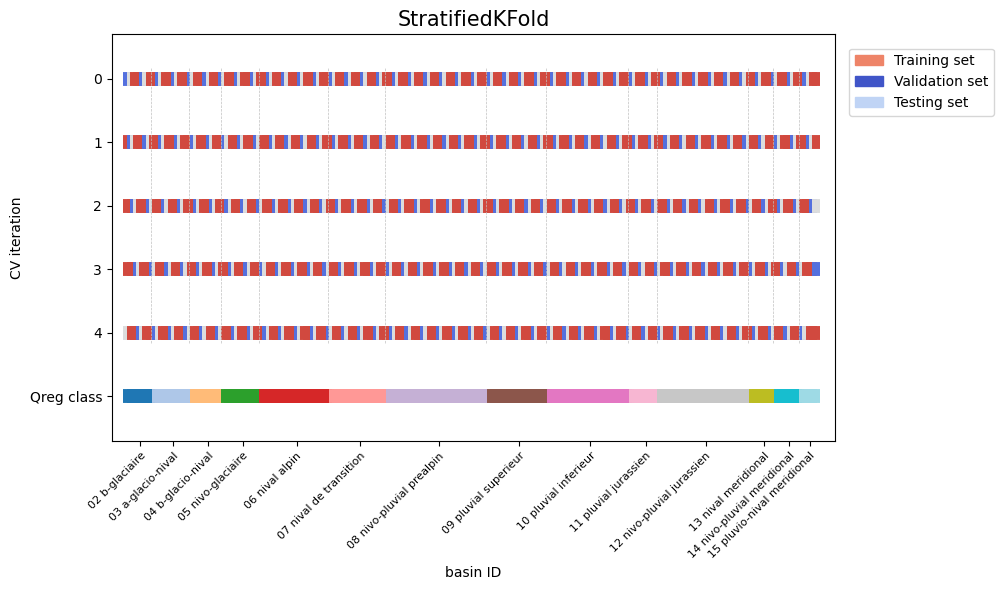

In [277]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the indices
plot_cv_indices(skf, train_indices, val_indices, test_indices,
                np.array(sorted_all_basins), encoded_classes,
                np.array(sorted_all_classes), ax, num_folds)
ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02)), Patch(color=cmap_cv(0.4))],
    ["Training set", "Validation set", "Testing set"],
    loc=(1.02, 0.8),
)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)

output_pdf = os.path.join("S:/tina/AML/P3", "ordered_Qreg_stratkfold_5folds.pdf")
plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

plt.show()

We need to shuffle a bit' things around. Let's do an outer and an inner stratified kfold splitting:

In [268]:
# Outer split to get test set
outer_skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
outer_splits = list(outer_skf.split(sorted_all_basins, sorted_all_classes))

train_indices_v2 = []
val_indices_v2 = []
test_indices_v2 = []

for fold_idx, (train_val_idx, test_idx) in enumerate(outer_splits):
    
    # Convert train_val_idx to a NumPy array for proper indexing
    train_val_idx = np.array(train_val_idx)

    # Split train_val_idx into train and validation sets (num_folds-1 splits for training, 1 split for validation)
    train_val_classes = np.array(sorted_all_classes)[train_val_idx]
    inner_skf = StratifiedKFold(n_splits=(num_folds-1), shuffle=True, random_state=seed)
    inner_splits = list(inner_skf.split(np.array(sorted_all_basins)[train_val_idx], train_val_classes))

    # Initialize an index to keep track of the current fold in the inner split
    inner_fold_idx = fold_idx % (num_folds-1)

    # Use the current fold for validation
    val_idx = inner_splits[inner_fold_idx][1]

    # Use the remaining folds for training
    inner_train_idx = np.setdiff1d(np.arange(len(train_val_idx)), val_idx)

    # Map the inner indices to the original indices
    train_idx = train_val_idx[inner_train_idx]
    val_idx = train_val_idx[val_idx]

    train_indices_v2.append(train_idx)
    val_indices_v2.append(val_idx)
    test_indices_v2.append(test_idx)

    # Debug prints (optional)
    print(f"fold_idx: {fold_idx}")
    print(f"train_val_idx: {train_val_idx}")
    print(f"len: {len(train_val_idx)}")
    print(f"test_idx: {test_idx}")
    print(f"len: {len(test_idx)}")
    print(f"train_idx: {train_idx}")
    print(f"len: {len(train_idx)}")
    print(f"val_idx: {val_idx}")
    print(f"len: {len(val_idx)}")


fold_idx: 0
train_val_idx: [  0   1   3   4   5   7   8   9  11  12  13  15  16  17  18  20  21  23
  24  26  27  28  29  30  31  32  33  34  35  36  37  38  40  42  45  46
  47  48  49  50  52  53  54  55  56  57  58  59  61  62  63  64  65  67
  68  69  72  73  74  75  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  95  96  97  99 101 102 104 105 107 108 109 110 111
 112 114 115 116 118 120 121 122 124 125 126 127 128 129 131 132 133 134
 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 153 155 156
 157 158 160 162 163 164 165 166 167 169 170 171 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 190 192 196 197 199 200 201 202
 204 205 206 207 208 209 210 211 212 215 216 217 218]
len: 175
test_idx: [  2   6  10  14  19  22  25  39  41  43  44  51  60  66  70  71  76  94
  98 100 103 106 113 117 119 123 130 135 136 139 154 159 161 168 172 189
 191 193 194 195 198 203 213 214]
len: 44
train_idx: [  0   1   4   7   8   9  12  13  15  16  17

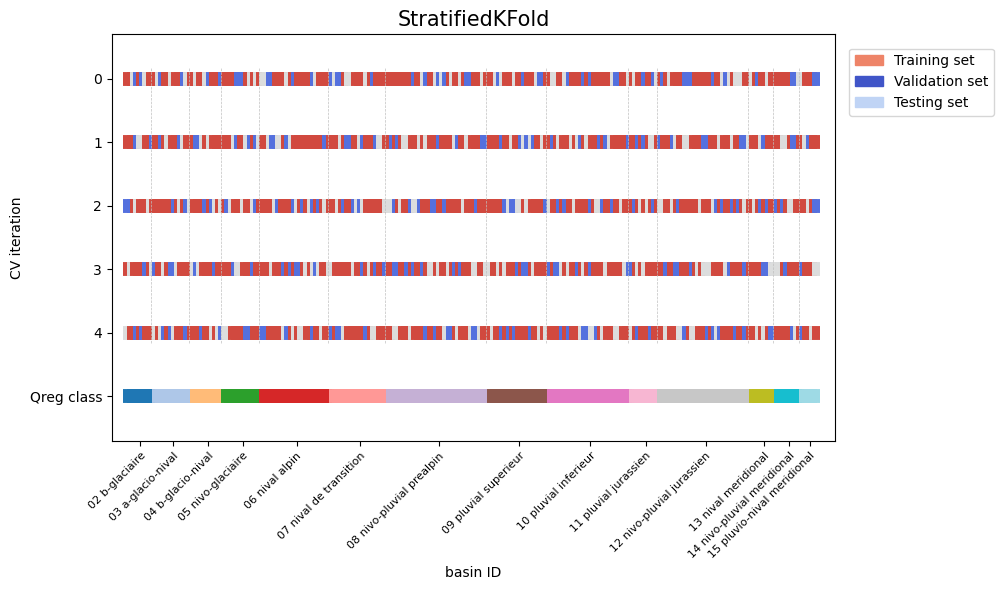

In [278]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the indices
plot_cv_indices(outer_skf, train_indices_v2, val_indices_v2, test_indices_v2,
                np.array(sorted_all_basins), encoded_classes, np.array(sorted_all_classes),
                ax, num_folds)
ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02)), Patch(color=cmap_cv(0.4))],
    ["Training set", "Validation set", "Testing set"],
    loc=(1.02, 0.8),
)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)

output_pdf = os.path.join("S:/tina/AML/P3", "outer_inner_Qreg_stratkfold_5folds.pdf")
plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

plt.show()

Let us check what it is exactly doing:

In [270]:
# Outer split to get test set
outer_skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
outer_splits = list(outer_skf.split(sorted_all_basins, sorted_all_classes))

train_indices_v2 = []
val_indices_v2 = []
test_indices_v2 = []

for fold_idx, (train_val_idx, test_idx) in enumerate(outer_splits):
    
    # Convert train_val_idx to a NumPy array for proper indexing
    train_val_idx = np.array(train_val_idx)

    # Split train_val_idx into train and validation sets (num_folds-1 splits for training, 1 split for validation)
    train_val_classes = np.array(sorted_all_classes)[train_val_idx]
    inner_skf = StratifiedKFold(n_splits=(num_folds-1), shuffle=True, random_state=seed)
    inner_splits = list(inner_skf.split(np.array(sorted_all_basins)[train_val_idx], train_val_classes))

    # Initialize an index to keep track of the current fold in the inner split
    inner_fold_idx = fold_idx % (num_folds-1)

    # Use the current fold for validation
    val_idx = inner_splits[inner_fold_idx][1]

    # Use the remaining folds for training
    inner_train_idx = np.setdiff1d(np.arange(len(train_val_idx)), val_idx)

    # Map the inner indices to the original indices
    train_idx = train_val_idx[inner_train_idx]
    val_idx = train_val_idx[val_idx]

    train_indices_v2.append(train_idx)
    val_indices_v2.append(val_idx)
    test_indices_v2.append(test_idx)

    # Debug prints (optional)
    print(f"fold_idx: {fold_idx}")
    print(f"train_val_idx: {train_val_idx}")
    print(f"len: {len(train_val_idx)}")
    print(f"test_idx: {test_idx}")
    print(f"len: {len(test_idx)}")
    print(f"train_idx: {train_idx}")
    print(f"len: {len(train_idx)}")
    print(f"val_idx: {val_idx}")
    print(f"len: {len(val_idx)}")


fold_idx: 0
train_val_idx: [  0   1   3   4   5   7   8   9  11  12  13  15  16  17  18  20  21  23
  24  26  27  28  29  30  31  32  33  34  35  36  37  38  40  42  45  46
  47  48  49  50  52  53  54  55  56  57  58  59  61  62  63  64  65  67
  68  69  72  73  74  75  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  95  96  97  99 101 102 104 105 107 108 109 110 111
 112 114 115 116 118 120 121 122 124 125 126 127 128 129 131 132 133 134
 137 138 140 141 142 143 144 145 146 147 148 149 150 151 152 153 155 156
 157 158 160 162 163 164 165 166 167 169 170 171 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 190 192 196 197 199 200 201 202
 204 205 206 207 208 209 210 211 212 215 216 217 218]
len: 175
test_idx: [  2   6  10  14  19  22  25  39  41  43  44  51  60  66  70  71  76  94
  98 100 103 106 113 117 119 123 130 135 136 139 154 159 161 168 172 189
 191 193 194 195 198 203 213 214]
len: 44
train_idx: [  0   1   4   7   8   9  12  13  15  16  17

In [271]:
train_basins = [sorted_all_basins[i] for i in train_idx]
val_basins = [sorted_all_basins[i] for i in val_idx]
test_basins = [sorted_all_basins[i] for i in test_idx]

Iteration 0
Train indices: [  0   1   4   7   8   9  12  13  15  16  17  20  21  23  24  27  28  29
  31  32  33  34  38  40  42  47  48  49  50  52  54  55  56  57  58  61
  62  63  64  69  72  73  74  75  77  79  80  81  82  83  84  85  86  87
  88  89  90  92  93  96  97 102 104 105 107 110 111 112 114 115 116 120
 121 122 124 125 127 128 129 133 134 137 138 141 142 143 144 146 148 149
 150 151 152 153 157 158 160 162 163 165 166 169 171 173 174 175 176 180
 181 182 183 184 185 187 188 192 196 197 199 201 202 204 205 206 207 208
 209 210 215 216 217]
Validation indices: [  3   5  11  18  26  30  35  36  37  45  46  53  59  65  67  68  78  91
  95  99 101 108 109 118 126 131 132 140 145 147 155 156 164 167 170 177
 178 179 186 190 200 211 212 218]
Test indices: [  2   6  10  14  19  22  25  39  41  43  44  51  60  66  70  71  76  94
  98 100 103 106 113 117 119 123 130 135 136 139 154 159 161 168 172 189
 191 193 194 195 198 203 213 214]
Iteration 1
Train indices: [  0   1   2   6   

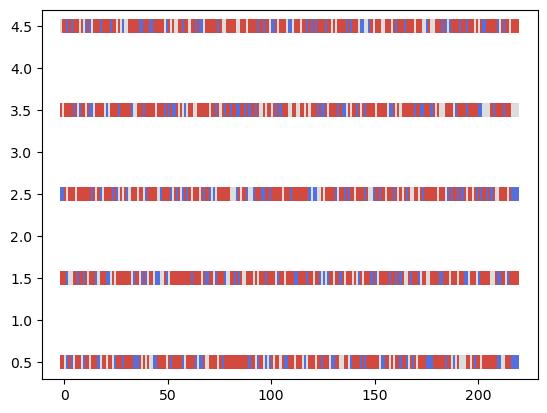

In [272]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_indices_v2, val_indices_v2, test_indices_v2, and sorted_all_basins are defined
# Assuming cmap_cv is defined

fig, ax = plt.subplots()

for ii, (train_idx, val_idx, test_idx) in enumerate(zip(train_indices_v2, val_indices_v2, test_indices_v2)):
    # Debug prints to check the indices
    print(f"Iteration {ii}")
    print(f"Train indices: {train_idx}")
    print(f"Validation indices: {val_idx}")
    print(f"Test indices: {test_idx}")

    # Fill in indices with the training/validation/testing groups
    indices = np.array([np.nan] * len(np.array(sorted_all_basins)))
    indices[test_idx] = 1  # Testing set
    indices[val_idx] = 0  # Validation set
    indices[train_idx] = 2  # Training set
    
    # Visualize the results
    ax.scatter(
        range(len(indices)),
        [ii + 0.5] * len(indices),
        c=indices,
        marker="_",
        lw=10,
        cmap=cmap_cv,
        vmin=-0.2,
        vmax=2.2,
    )

# Display the plot
plt.show()

Looks fine. Now let us try some other king of visualization, to check quantitatively the sample sizes of training, validation and test data sets:

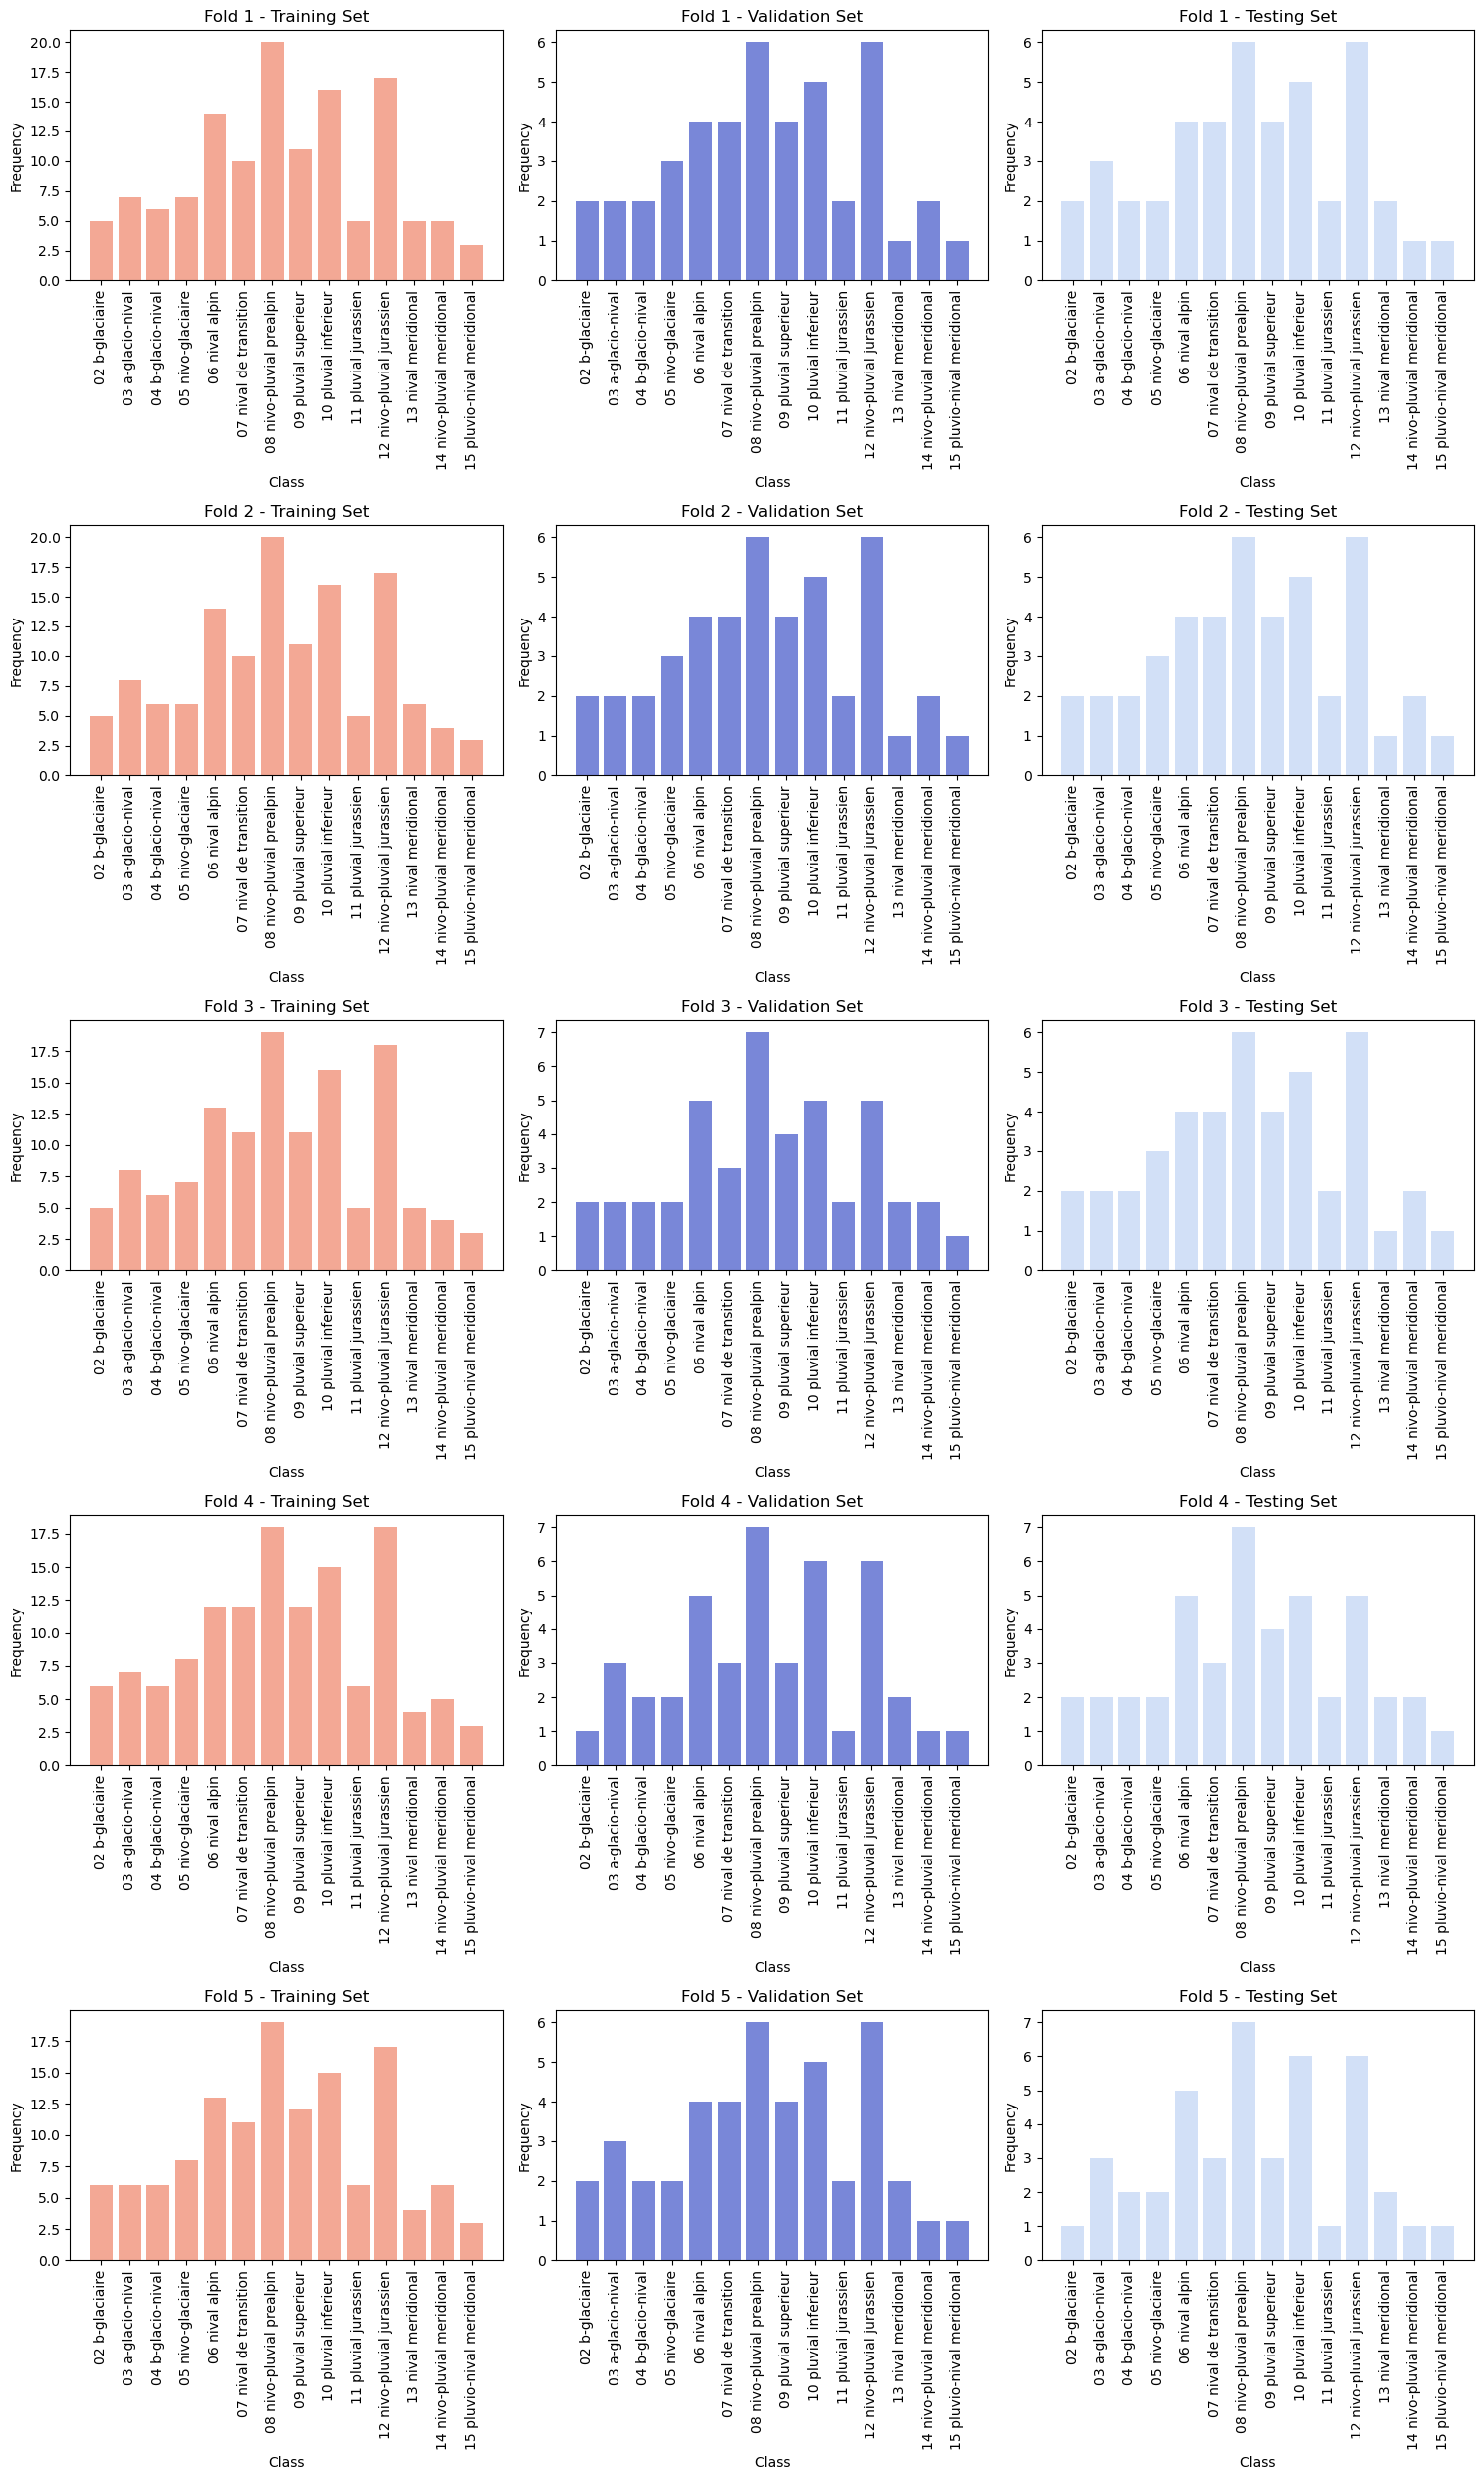

In [273]:
num_folds = len(train_indices_v2)
num_classes = len(np.unique(sorted_all_classes))

# Get the mapping from numerical labels to original labels
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

fig, axes = plt.subplots(num_folds, 3, figsize=(15, 5 * num_folds))

for ii, (train_idx, val_idx, test_idx) in enumerate(zip(train_indices_v2, val_indices_v2, test_indices_v2)):
    # Get class labels for each set
    train_labels = encoded_classes[train_idx]
    val_labels = encoded_classes[val_idx]
    test_labels = encoded_classes[test_idx]

    # Debug: Print the unique class labels and their counts
    #print(f"Fold {ii+1} - Training Set: {np.unique(train_labels, return_counts=True)}")
    #print(f"Fold {ii+1} - Validation Set: {np.unique(val_labels, return_counts=True)}")
    #print(f"Fold {ii+1} - Testing Set: {np.unique(test_labels, return_counts=True)}")
    
    # Create histograms
    train_hist, _ = np.histogram(train_labels, bins=np.arange(num_classes + 1) - 0.5)
    val_hist, _ = np.histogram(val_labels, bins=np.arange(num_classes + 1) - 0.5)
    test_hist, _ = np.histogram(test_labels, bins=np.arange(num_classes + 1) - 0.5)

    # Debug: Print the histogram values
    #print(f"Fold {ii+1} - Training Histogram: {train_hist}")
    #print(f"Fold {ii+1} - Validation Histogram: {val_hist}")
    #print(f"Fold {ii+1} - Testing Histogram: {test_hist}")
    
    # Plot histograms
    axes[ii, 0].bar(np.arange(num_classes), train_hist, color = cmap_cv(0.8), alpha=0.7)
    axes[ii, 0].set_title(f'Fold {ii+1} - Training Set')
    axes[ii, 0].set_xlabel('Class')
    axes[ii, 0].set_ylabel('Frequency')
    axes[ii, 0].set_xticks(np.arange(num_classes))
    axes[ii, 0].set_xticklabels([label_mapping[i] for i in range(num_classes)], rotation=90)
    
    axes[ii, 1].bar(np.arange(num_classes), val_hist, color = cmap_cv(0.02), alpha=0.7)
    axes[ii, 1].set_title(f'Fold {ii+1} - Validation Set')
    axes[ii, 1].set_xlabel('Class')
    axes[ii, 1].set_ylabel('Frequency')
    axes[ii, 1].set_xticks(np.arange(num_classes))
    axes[ii, 1].set_xticklabels([label_mapping[i] for i in range(num_classes)], rotation=90)
    
    axes[ii, 2].bar(np.arange(num_classes), test_hist, color = cmap_cv(0.4), alpha=0.7)
    axes[ii, 2].set_title(f'Fold {ii+1} - Testing Set')
    axes[ii, 2].set_xlabel('Class')
    axes[ii, 2].set_ylabel('Frequency')
    axes[ii, 2].set_xticks(np.arange(num_classes))
    axes[ii, 2].set_xticklabels([label_mapping[i] for i in range(num_classes)], rotation=90)

plt.tight_layout()
plt.show()

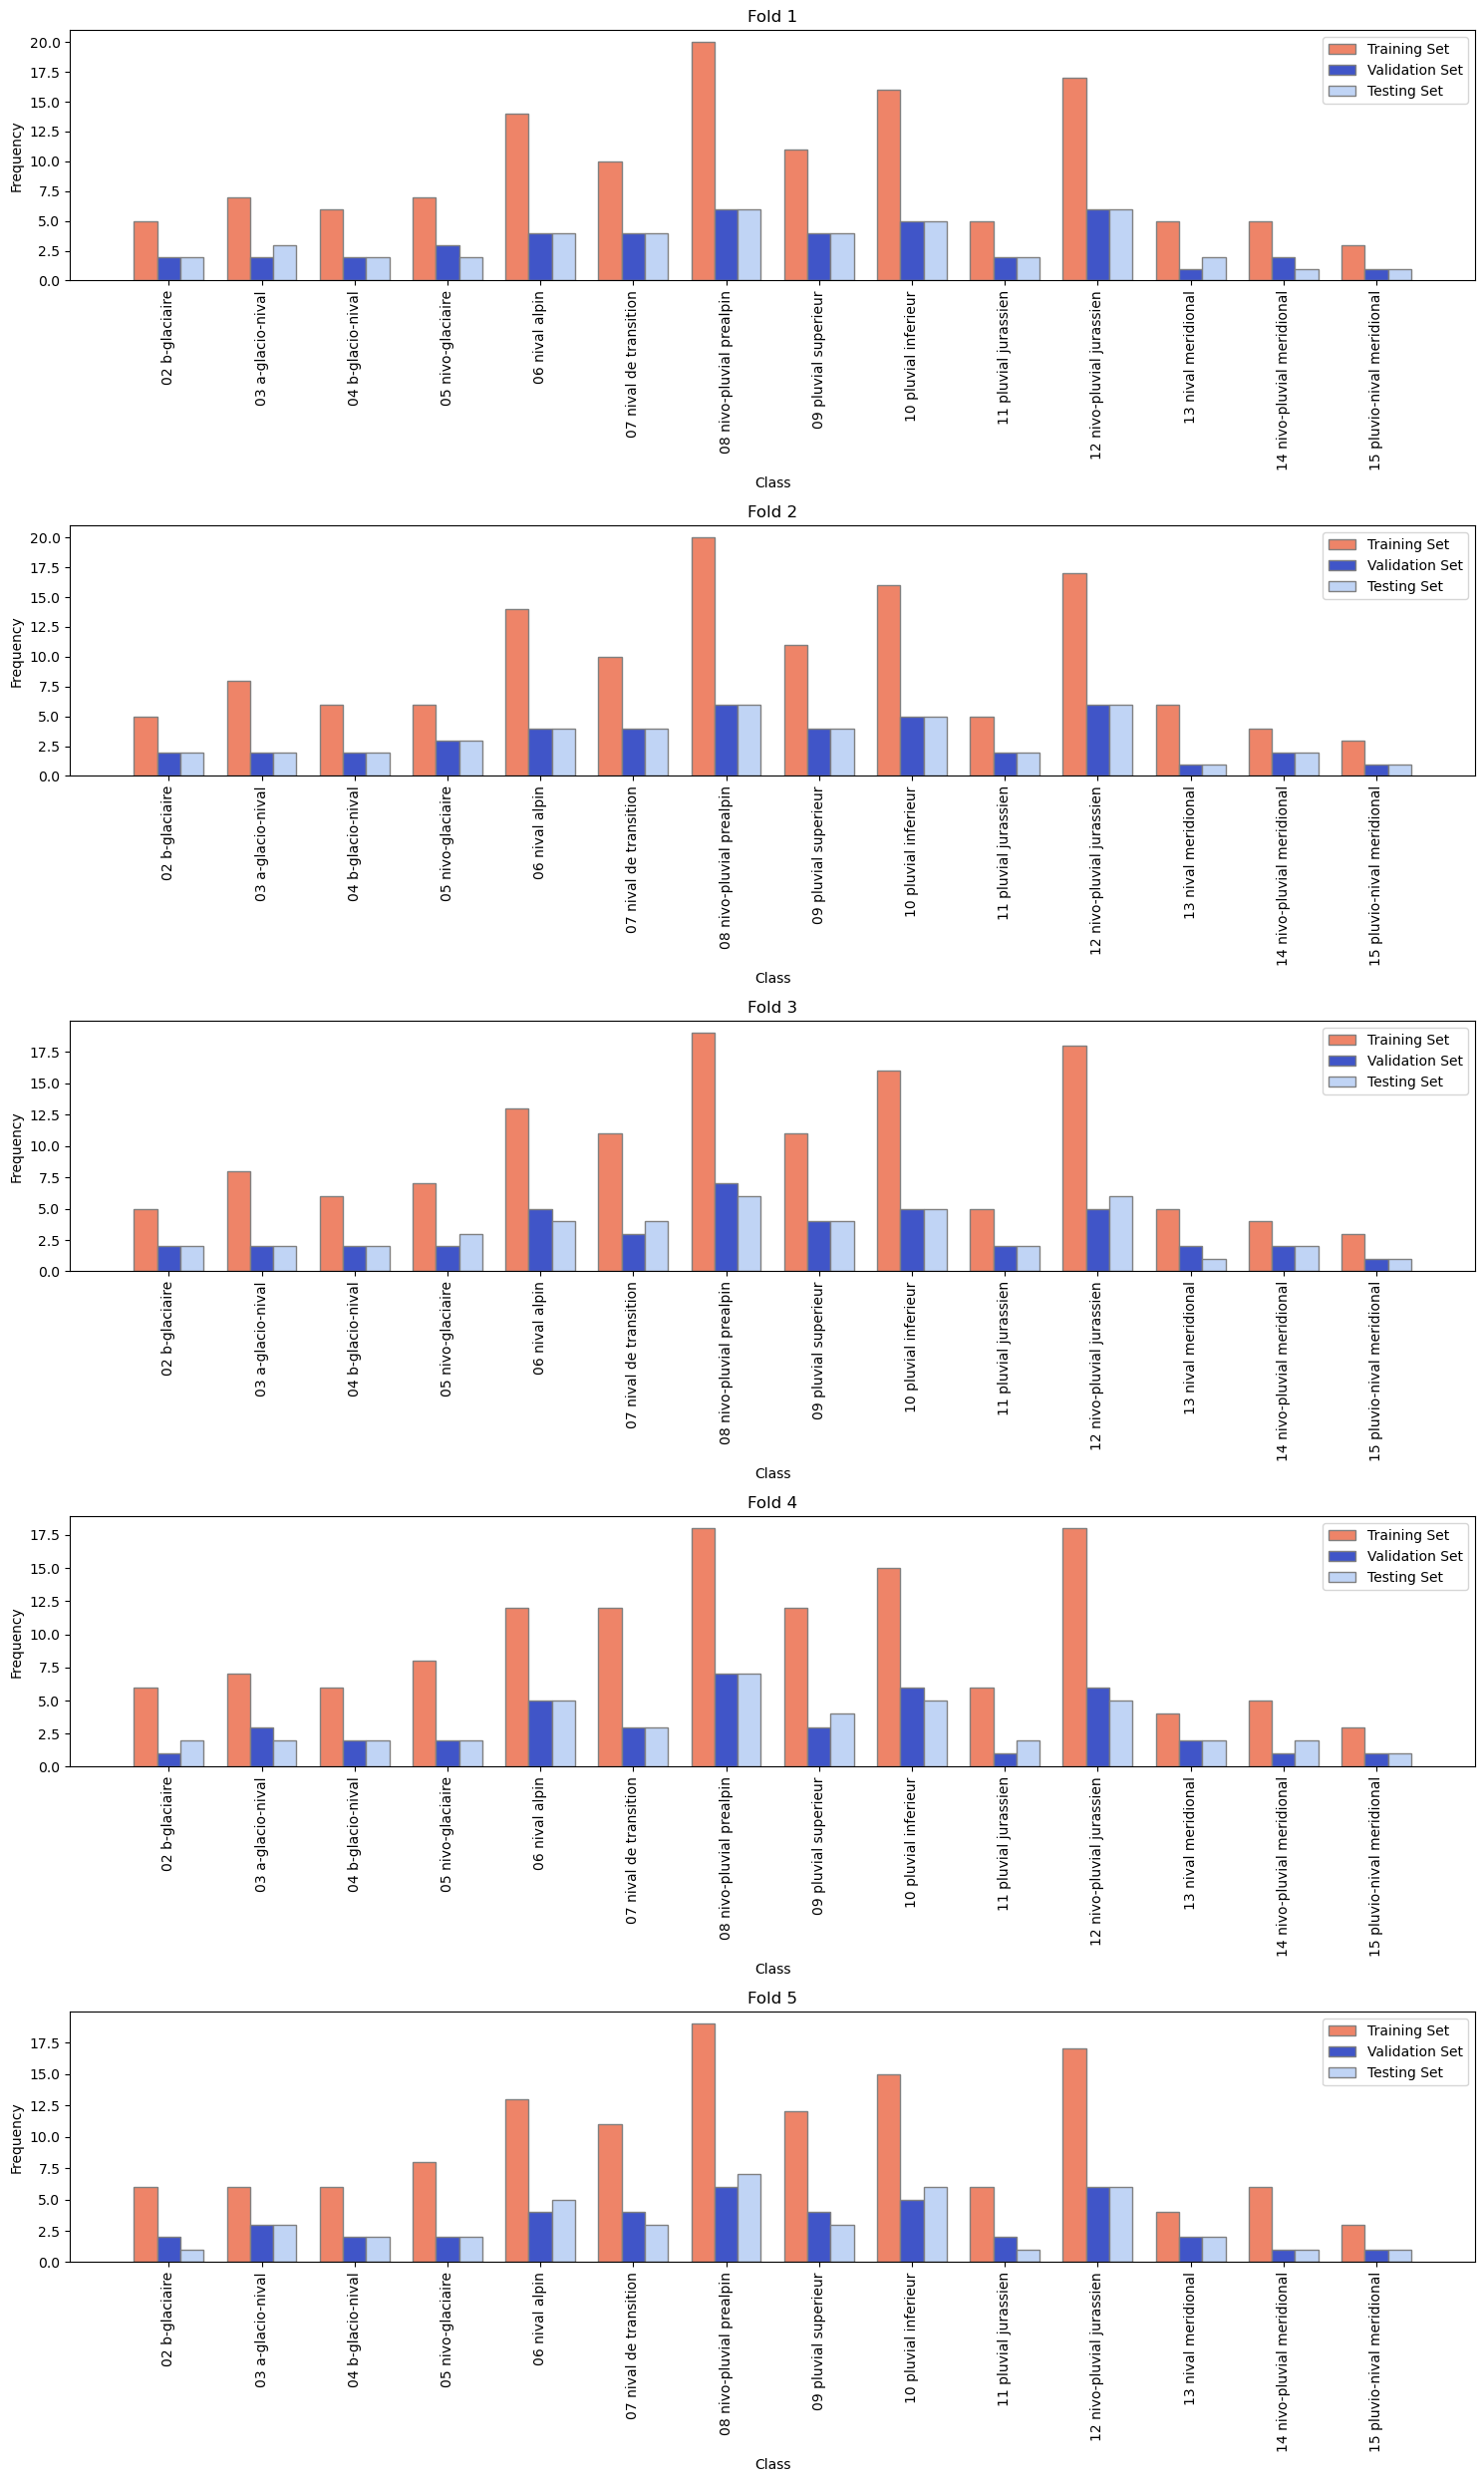

In [274]:
fig, axes = plt.subplots(num_folds, 1, figsize=(15, 5 * num_folds))

for ii, (train_idx, val_idx, test_idx) in enumerate(zip(train_indices_v2, val_indices_v2, test_indices_v2)):
    # Get numerical class labels for each set
    train_labels = encoded_classes[train_idx]
    val_labels = encoded_classes[val_idx]
    test_labels = encoded_classes[test_idx]
    
    # Create histograms
    train_hist, _ = np.histogram(train_labels, bins=np.arange(num_classes + 1) - 0.5)
    val_hist, _ = np.histogram(val_labels, bins=np.arange(num_classes + 1) - 0.5)
    test_hist, _ = np.histogram(test_labels, bins=np.arange(num_classes + 1) - 0.5)
    
    # Plot histograms
    bar_width = 0.25
    r1 = np.arange(num_classes)
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    axes[ii].bar(r1, train_hist, color=cmap_cv(0.8), width=bar_width, edgecolor='grey', label='Training Set')
    axes[ii].bar(r2, val_hist, color=cmap_cv(0.02), width=bar_width, edgecolor='grey', label='Validation Set')
    axes[ii].bar(r3, test_hist, color=cmap_cv(0.4), width=bar_width, edgecolor='grey', label='Testing Set')
    
    axes[ii].set_title(f'Fold {ii+1}')
    axes[ii].set_xlabel('Class')
    axes[ii].set_ylabel('Frequency')
    axes[ii].set_xticks([r + bar_width for r in range(num_classes)])
    axes[ii].set_xticklabels([label_mapping[i] for i in range(num_classes)], rotation=90)
    axes[ii].legend()

plt.tight_layout()
plt.show()

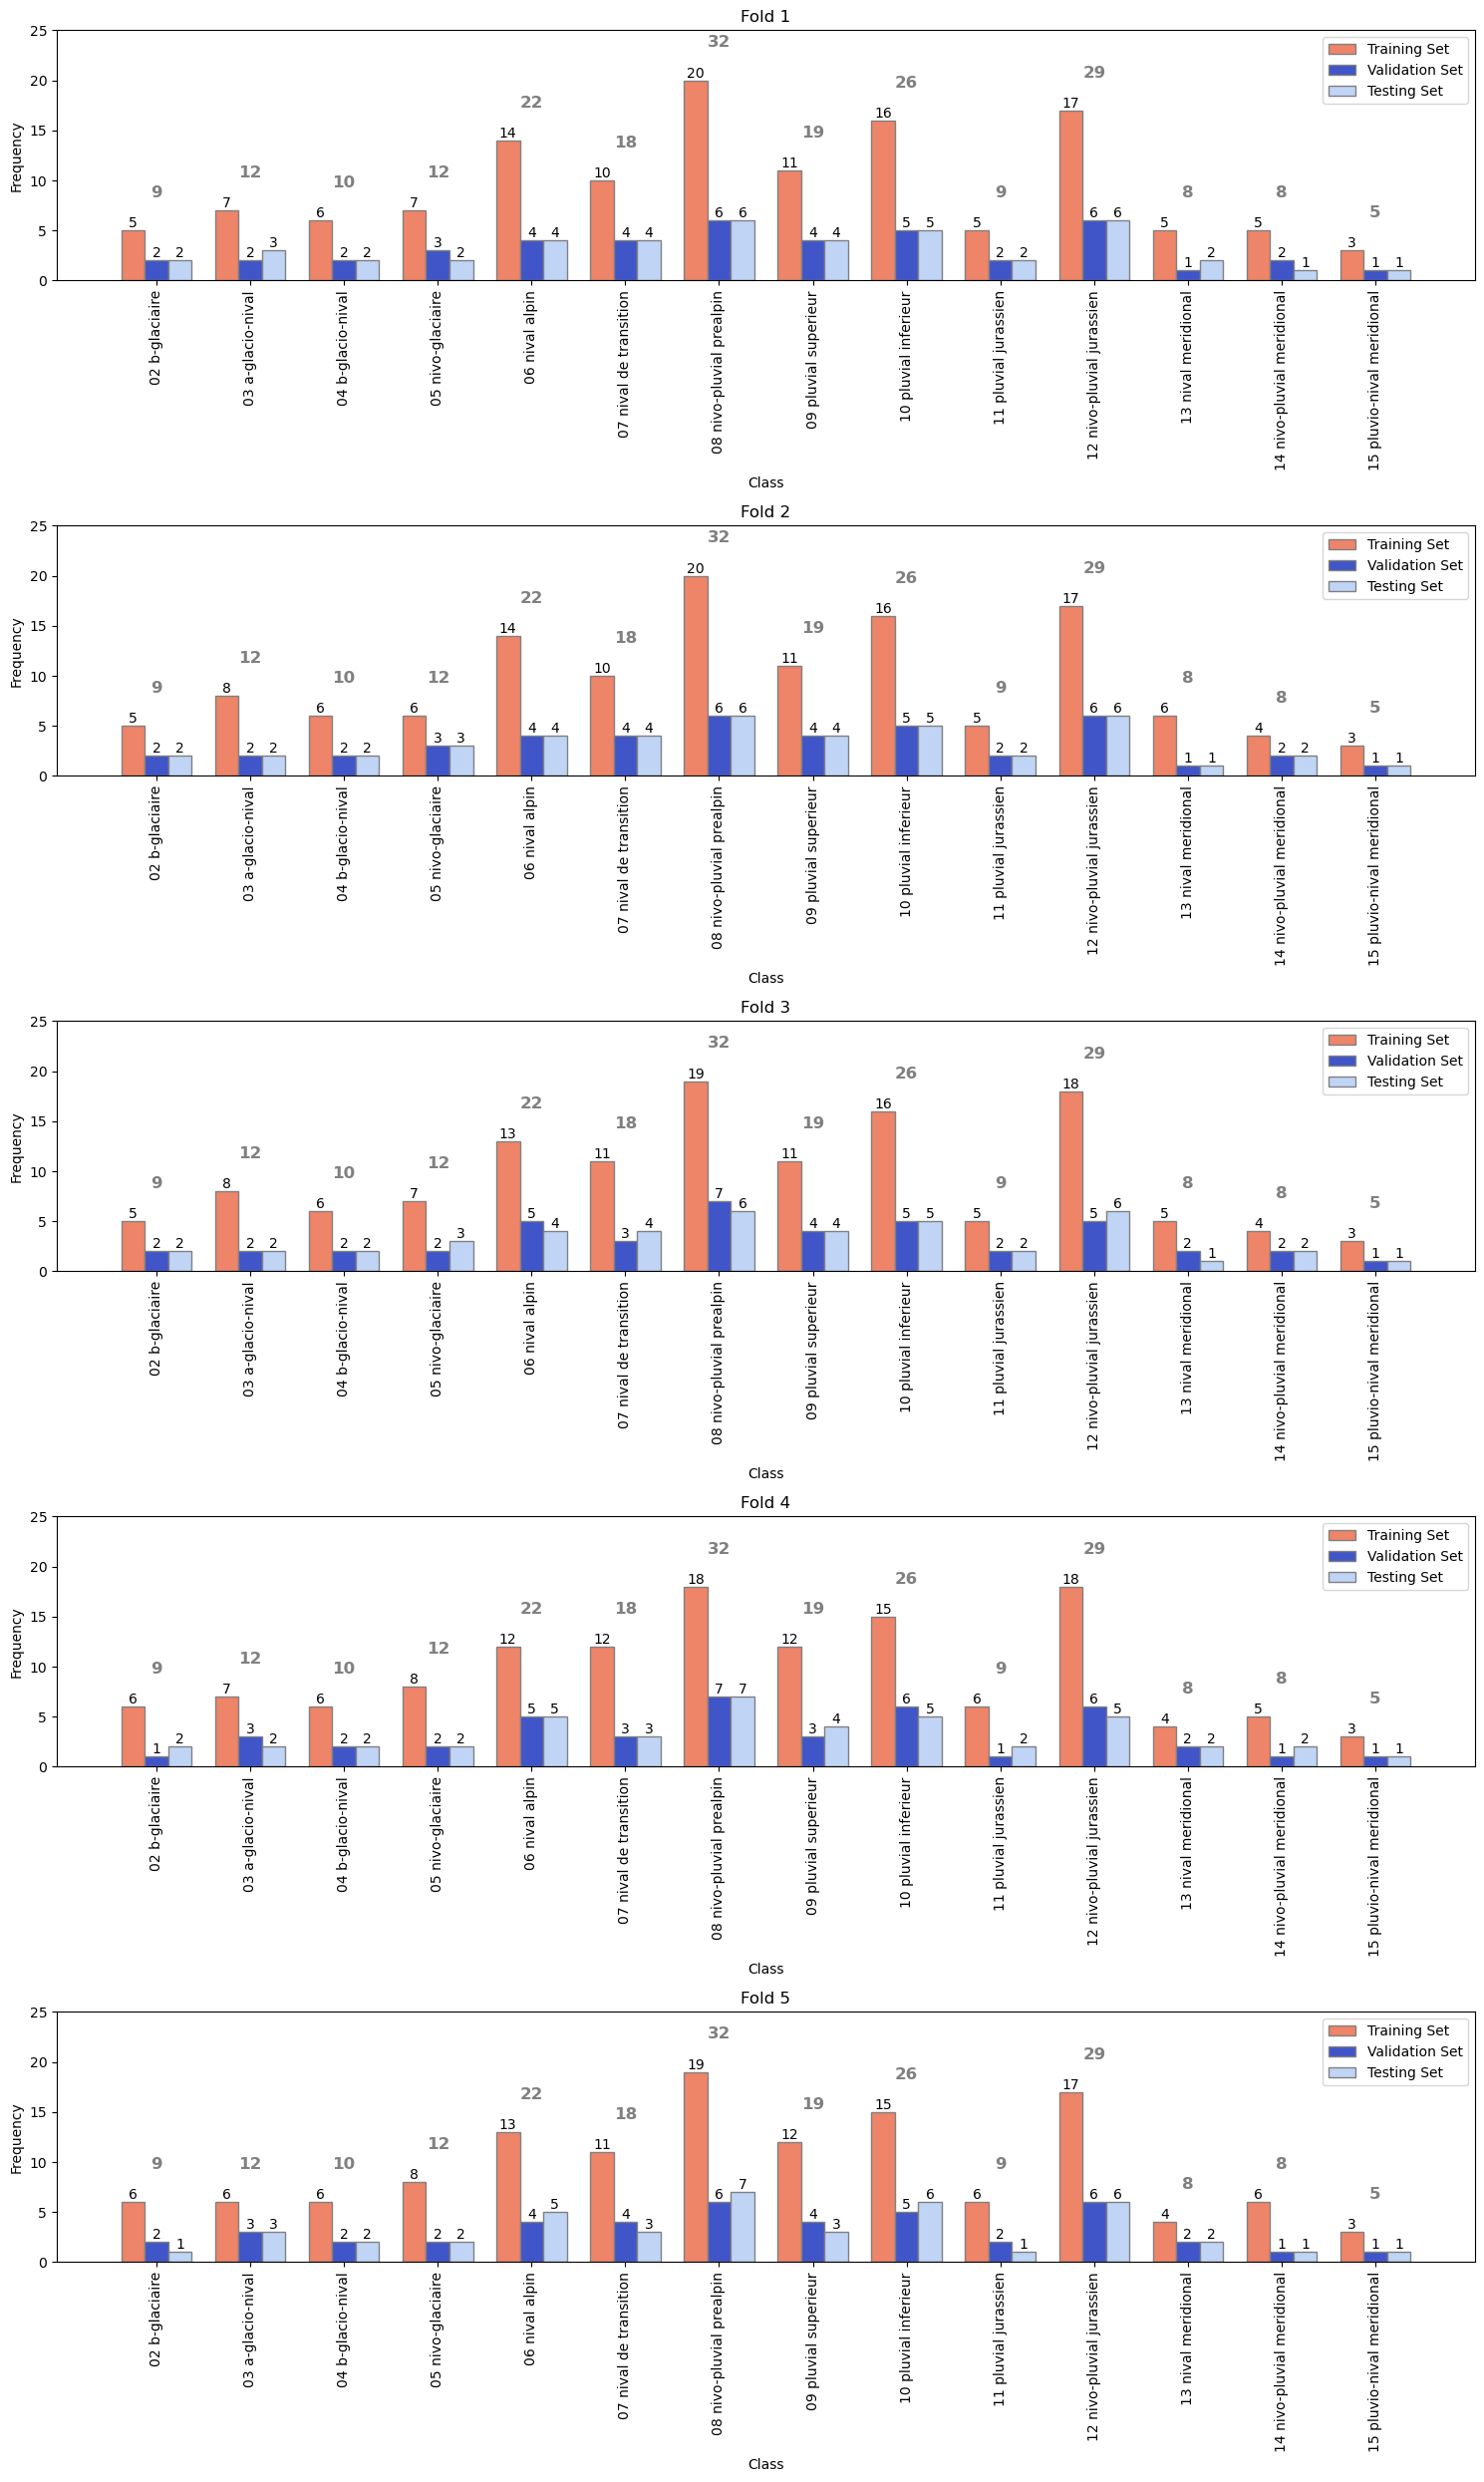

In [275]:
fig, axes = plt.subplots(num_folds, 1, figsize=(15, 5 * num_folds))

for ii, (train_idx, val_idx, test_idx) in enumerate(zip(train_indices_v2, val_indices_v2, test_indices_v2)):
    # Get numerical class labels for each set
    train_labels = encoded_classes[train_idx]
    val_labels = encoded_classes[val_idx]
    test_labels = encoded_classes[test_idx]
    
    # Create histograms
    train_hist, _ = np.histogram(train_labels, bins=np.arange(num_classes + 1) - 0.5)
    val_hist, _ = np.histogram(val_labels, bins=np.arange(num_classes + 1) - 0.5)
    test_hist, _ = np.histogram(test_labels, bins=np.arange(num_classes + 1) - 0.5)
    
    # Plot histograms
    bar_width = 0.25
    r1 = np.arange(num_classes)
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    bars1 = axes[ii].bar(r1, train_hist, color=cmap_cv(0.8),
                         width=bar_width, edgecolor='grey',
                         label='Training Set')
    bars2 = axes[ii].bar(r2, val_hist, color=cmap_cv(0.02),
                         width=bar_width, edgecolor='grey',
                         label='Validation Set')
    bars3 = axes[ii].bar(r3, test_hist, color=cmap_cv(0.4),
                         width=bar_width, edgecolor='grey',
                         label='Testing Set')
    
    # Add frequency numbers on each bar
    for bar in bars1:
        height = bar.get_height()
        axes[ii].text(bar.get_x() + bar.get_width() / 2.0,
                      height, f'{int(height)}', ha='center', va='bottom')
    
    for bar in bars2:
        height = bar.get_height()
        axes[ii].text(bar.get_x() + bar.get_width() / 2.0, 
                      height, f'{int(height)}', ha='center', va='bottom')
    
    for bar in bars3:
        height = bar.get_height()
        axes[ii].text(bar.get_x() + bar.get_width() / 2.0,
                    height, f'{int(height)}', ha='center', va='bottom')
    
    # Add total number of samples above the training set bars
    for j, bar in enumerate(bars1):
        total_samples = train_hist[j] + val_hist[j] + test_hist[j]
        axes[ii].text(bar.get_x() + bar.get_width() * 1.5, 
                      bar.get_height() + 3, f'{int(total_samples)}',
                      ha='center', va='bottom', fontsize=12,
                      color='grey', weight="bold")
    
    axes[ii].set_title(f'Fold {ii+1}')
    axes[ii].set_ylim([0, 25])
    axes[ii].set_xlabel('Class')
    axes[ii].set_ylabel('Frequency')
    axes[ii].set_xticks([r + bar_width for r in range(num_classes)])
    axes[ii].set_xticklabels([label_mapping[i] for i in range(num_classes)], rotation=90)
    axes[ii].legend()

plt.tight_layout()

# Save plot as A4 PDF
output_pdf = os.path.join("S:/tina/AML/P3", "Qreg_strat_kfold_splits.pdf")
plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

plt.show()

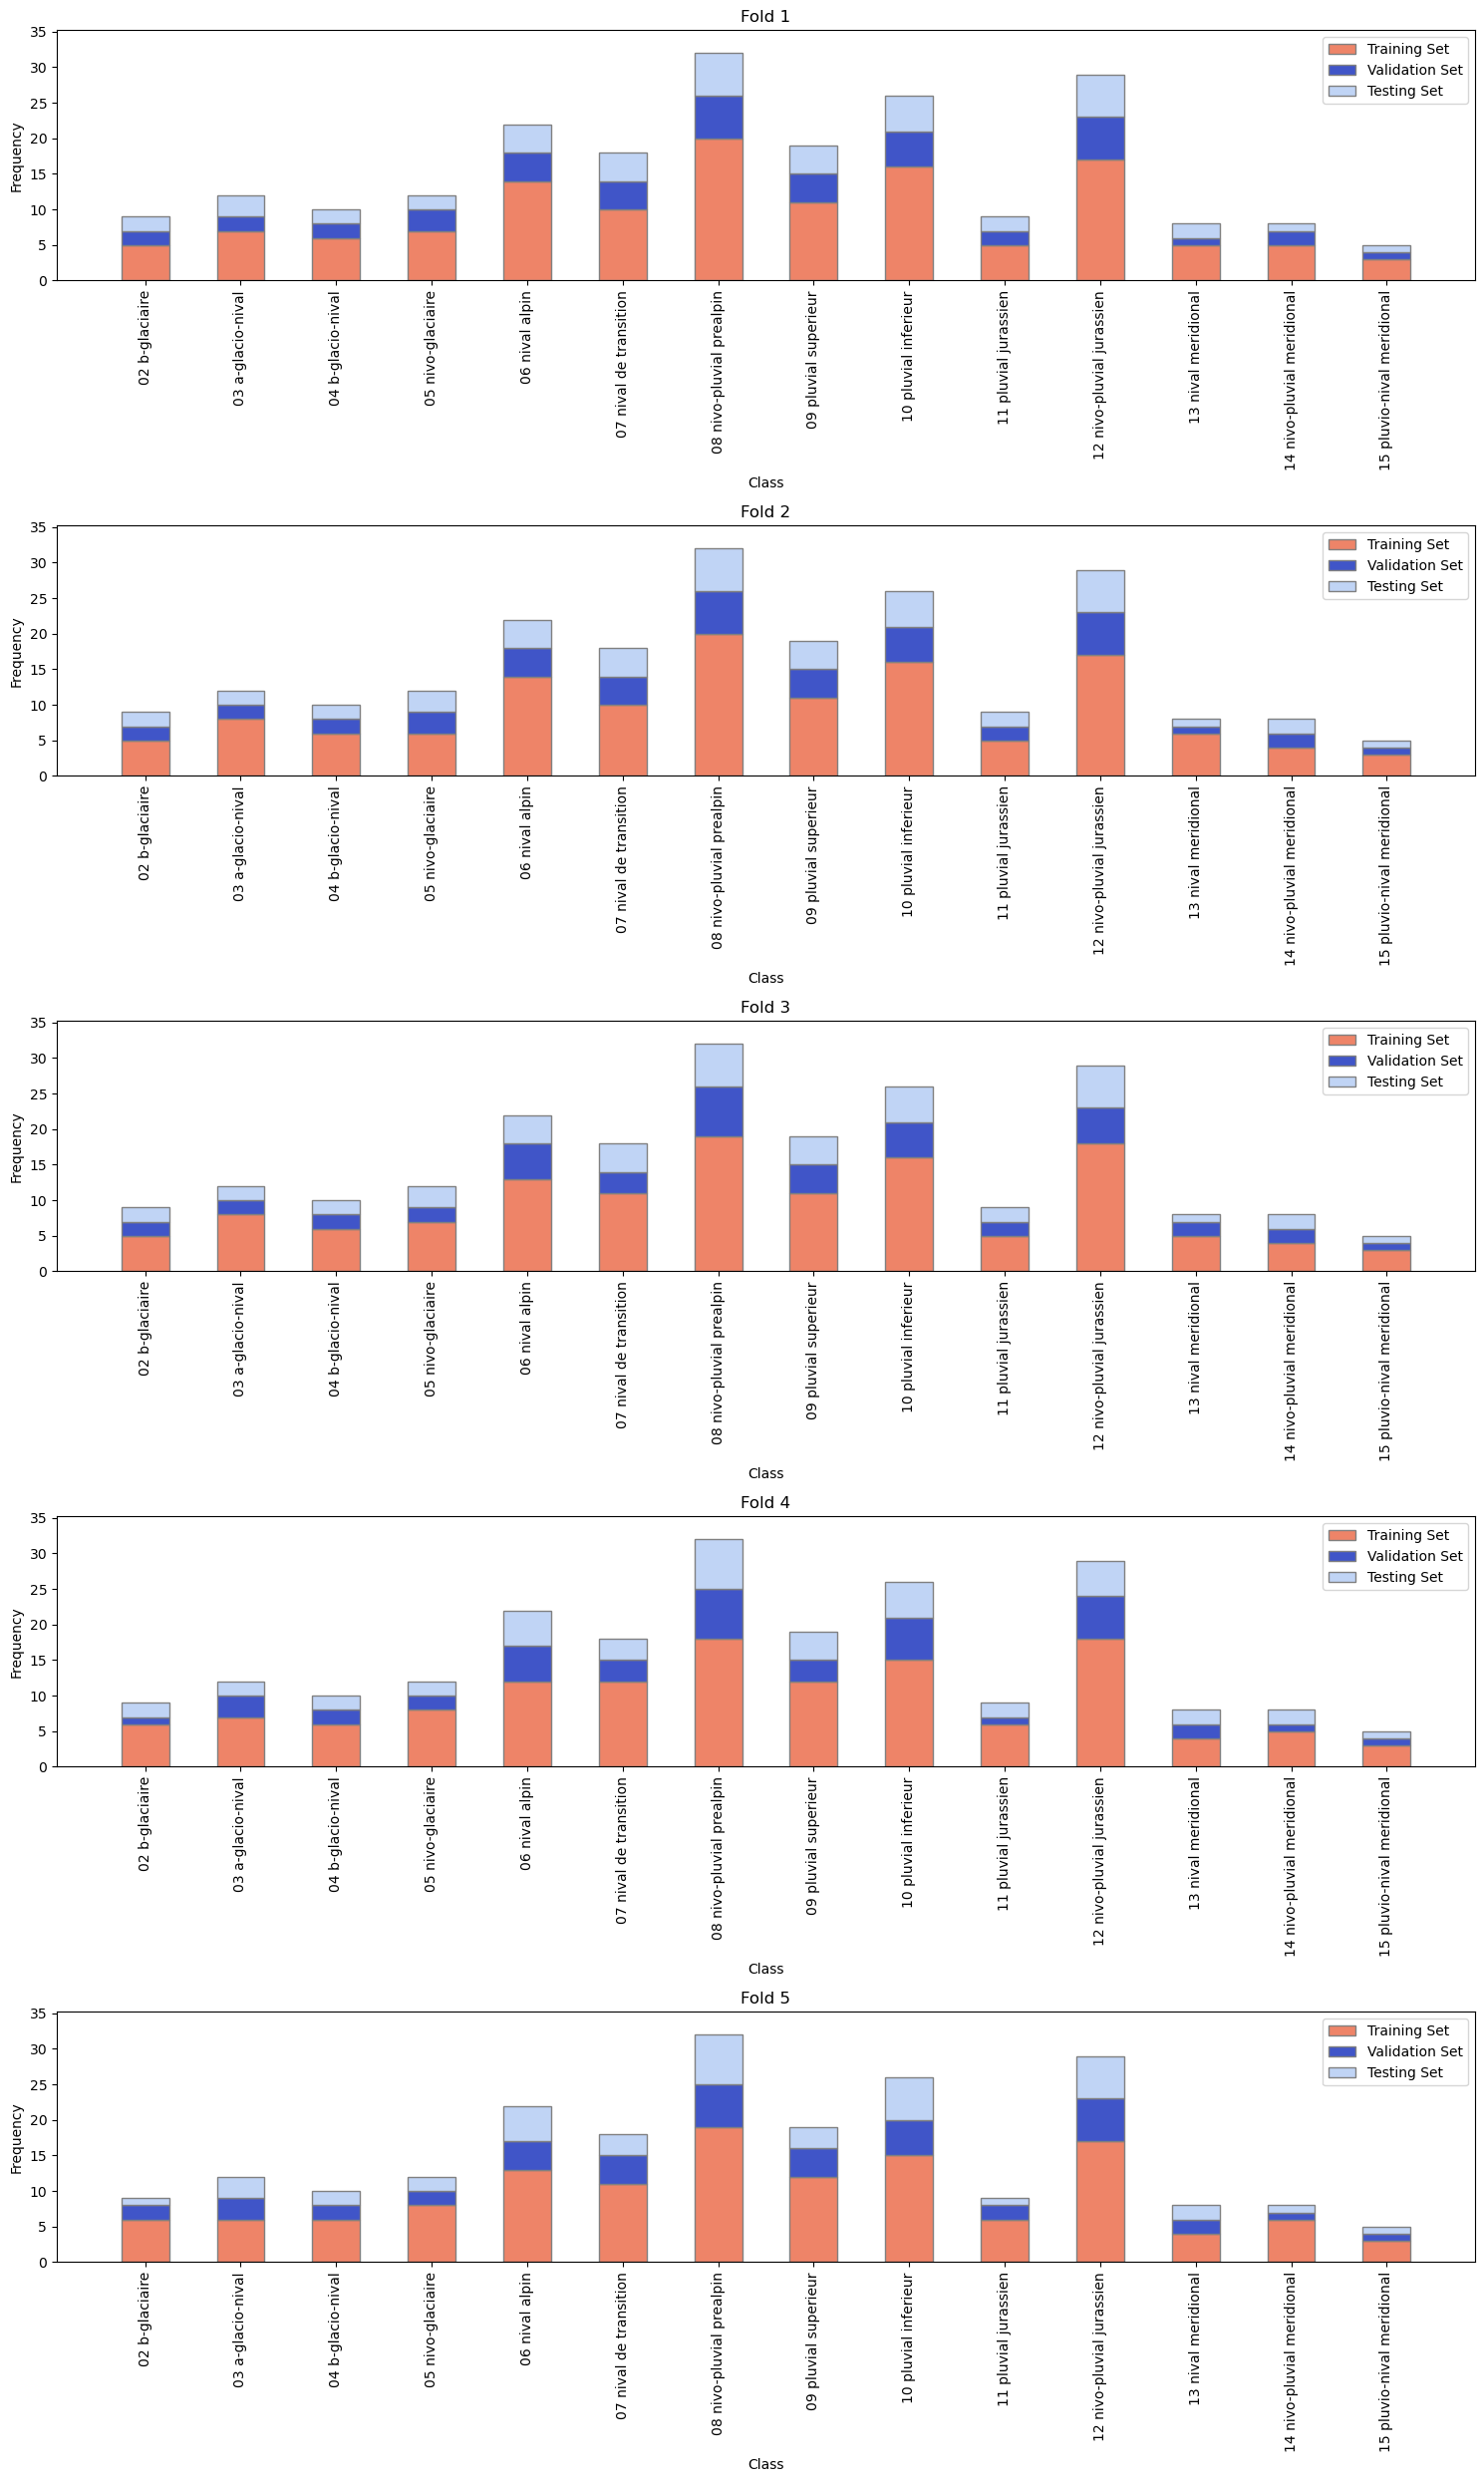

In [276]:
fig, axes = plt.subplots(num_folds, 1, figsize=(15, 5 * num_folds))

for ii, (train_idx, val_idx, test_idx) in enumerate(zip(train_indices_v2, val_indices_v2, test_indices_v2)):
    # Get numerical class labels for each set
    train_labels = encoded_classes[train_idx]
    val_labels = encoded_classes[val_idx]
    test_labels = encoded_classes[test_idx]
    
    # Create histograms
    train_hist, _ = np.histogram(train_labels, bins=np.arange(num_classes + 1) - 0.5)
    val_hist, _ = np.histogram(val_labels, bins=np.arange(num_classes + 1) - 0.5)
    test_hist, _ = np.histogram(test_labels, bins=np.arange(num_classes + 1) - 0.5)
    
    # Plot stacked histograms
    bar_width = 0.5
    r = np.arange(num_classes)
    
    bars1 = axes[ii].bar(r, train_hist, color=cmap_cv(0.8), width=bar_width, edgecolor='grey', label='Training Set')
    bars2 = axes[ii].bar(r, val_hist, bottom=train_hist, color=cmap_cv(0.02), width=bar_width, edgecolor='grey', label='Validation Set')
    bars3 = axes[ii].bar(r, test_hist, bottom=train_hist + val_hist, color=cmap_cv(0.4), width=bar_width, edgecolor='grey', label='Testing Set')
    
    axes[ii].set_title(f'Fold {ii+1}')
    axes[ii].set_ylim([0, max(train_hist + val_hist + test_hist) * 1.1])
    axes[ii].set_xlabel('Class')
    axes[ii].set_ylabel('Frequency')
    axes[ii].set_xticks(r)
    axes[ii].set_xticklabels([label_mapping[i] for i in range(num_classes)], rotation=90)
    axes[ii].legend()

plt.tight_layout()
plt.show()

In [301]:
run_path = 'S:\tina\AML\P3\RR-Former\runs\LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet168_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone'
# Define the directory path
directory_path = run_path  # Ensure run_path is defined

# Ensure the directory exists
if not os.path.exists(directory_path):
    print(f"Directory not found: {directory_path}")
else:
    # List all .json files in the directory
    json_files = glob.glob(os.path.join(directory_path, '*.json'))
    
    # Print the list of .json files
    print("JSON files found:")
    for json_file in json_files:
        print(json_file)

uns\LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet168_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone


In [10]:
import json
import os

# Define the path to the JSON file
json_file_path = 'S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet168_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone/y_stds_dict.json'

# Check if the file exists
if not os.path.exists(json_file_path):
    print(f"File not found: {json_file_path}")
else:
    # Open and load the JSON file
    with open(json_file_path, 'r') as file:
        y_stds_dict = json.load(file)
    
    # Print the contents of the JSON file
    print(json.dumps(y_stds_dict, indent=4))

{
    "2009": 1.6851286888122559,
    "2011": 2.1564273834228516,
    "2016": 1.102076530456543,
    "2018": 2.083503484725952,
    "2019": 3.7329413890838623,
    "2020": 3.780430793762207,
    "2024": 1.9878268241882324,
    "2029": 1.2276090383529663,
    "2030": 2.530837059020996,
    "2033": 3.015470027923584,
    "2034": 2.3305959701538086,
    "2044": 2.5823793411254883,
    "2056": 3.8181302547454834,
    "2063": 1.1967226266860962,
    "2067": 2.0101470947265625,
    "2070": 2.526977300643921,
    "2078": 2.63523268699646,
    "2079": 14.689435958862305,
    "2084": 4.773069858551025,
    "2085": 1.5836683511734009,
    "2086": 2.264859437942505,
    "2087": 3.4622418880462646,
    "2091": 1.1101549863815308,
    "2099": 1.9616529941558838,
    "2102": 1.711418867111206,
    "2104": 2.525132179260254,
    "2105": 3.258338689804077,
    "2106": 1.6627042293548584,
    "2109": 4.09956169128418,
    "2110": 2.2992208003997803,
    "2112": 4.901179313659668,
    "2117": 0.71983861

In [305]:
import json
import os

# Define the path to the JSON file
json_file_path = 'S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet219#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n150_bs512_lr0.001_wd0.01_warm_up@seed12/global_y_stds_dict.json'

# Check if the file exists
if not os.path.exists(json_file_path):
    print(f"File not found: {json_file_path}")
else:
    # Open and load the JSON file
    with open(json_file_path, 'r') as file:
        y_stds_dict = json.load(file)
    
    # Print the contents of the JSON file
    print(json.dumps(y_stds_dict, indent=4))

{
    "2009": 1.6851286888122559,
    "2011": 2.1564273834228516,
    "2016": 1.102076530456543,
    "2018": 2.083503484725952,
    "2019": 3.7329413890838623,
    "2020": 3.780430793762207,
    "2024": 1.9878268241882324,
    "2029": 1.2276090383529663,
    "2030": 2.530837059020996,
    "2033": 3.015470027923584,
    "2034": 2.3305959701538086,
    "2044": 2.5823793411254883,
    "2053": 0.8737599849700928,
    "2056": 3.8181302547454834,
    "2063": 1.1967226266860962,
    "2067": 2.0101470947265625,
    "2070": 2.526977300643921,
    "2078": 2.63523268699646,
    "2079": 14.689435958862305,
    "2084": 4.773069858551025,
    "2085": 1.5836683511734009,
    "2086": 2.264859437942505,
    "2087": 3.4622418880462646,
    "2091": 1.1101549863815308,
    "2099": 1.9616529941558838,
    "2102": 1.711418867111206,
    "2104": 2.525132179260254,
    "2105": 3.258338689804077,
    "2106": 1.6627042293548584,
    "2109": 4.09956169128418,
    "2110": 2.2992208003997803,
    "2112": 4.9011793

In [306]:
import json
import os

# Define the path to the JSON file
json_file_path = 'S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet219#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n150_bs512_lr0.001_wd0.01_warm_up@seed12/fold0/y_stds_dict_fold_0.json'

# Check if the file exists
if not os.path.exists(json_file_path):
    print(f"File not found: {json_file_path}")
else:
    # Open and load the JSON file
    with open(json_file_path, 'r') as file:
        y_stds_dict = json.load(file)
    
    # Print the contents of the JSON file
    print(json.dumps(y_stds_dict, indent=4))

{
    "2016": 1.102076530456543,
    "2020": 3.780430793762207,
    "2030": 2.530837059020996,
    "2044": 2.5823793411254883,
    "2063": 1.1967226266860962,
    "2078": 2.63523268699646,
    "2085": 1.5836683511734009,
    "2091": 1.1101549863815308,
    "2104": 2.525132179260254,
    "2109": 4.09956169128418,
    "2117": 0.7198386192321777,
    "2125": 1.1294069290161133,
    "2135": 2.183008909225464,
    "2143": 1.0401742458343506,
    "2152": 2.6290814876556396,
    "2159": 1.7173978090286255,
    "2167": 3.433788776397705,
    "2176": 1.7660058736801147,
    "2185": 2.199043035507202,
    "2200": 4.39453649520874,
    "2205": 1.2899104356765747,
    "2215": 1.6885383129119873,
    "2239": 0.19772225618362427,
    "2247": 2.626241445541382,
    "2256": 5.242307186126709,
    "2265": 1.5051101446151733,
    "2270": 2.7018425464630127,
    "2283": 4.570798397064209,
    "2290": 5.154604911804199,
    "2303": 4.3802080154418945,
    "2307": 2.6876320838928223,
    "2312": 2.05858945

In [4]:
import os
import pandas as pd

sim_dir = 'S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet219#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n150_bs512_lr0.001_wd0.01_warm_up@seed12'
fold = "fold0"
fn = "log_train.csv"

file_path = os.path.join(sim_dir, fold, fn)

df = pd.read_csv(file_path, skiprows=1)
print(df.head())

   epoch  train_loss_iterated  train_mse   val_mse  train_nse   val_nse
0      0             0.032416   0.327136  0.277223   0.337345  0.158982
1      0             0.013882   0.156453  0.185889   0.803320  0.552967
2      0             0.033294   0.335233  0.277908   0.317075  0.138567
3      1             0.013944   0.200921  0.193367   0.716079  0.528487
4      0             0.011654   0.142428  0.170005   0.831909  0.373344


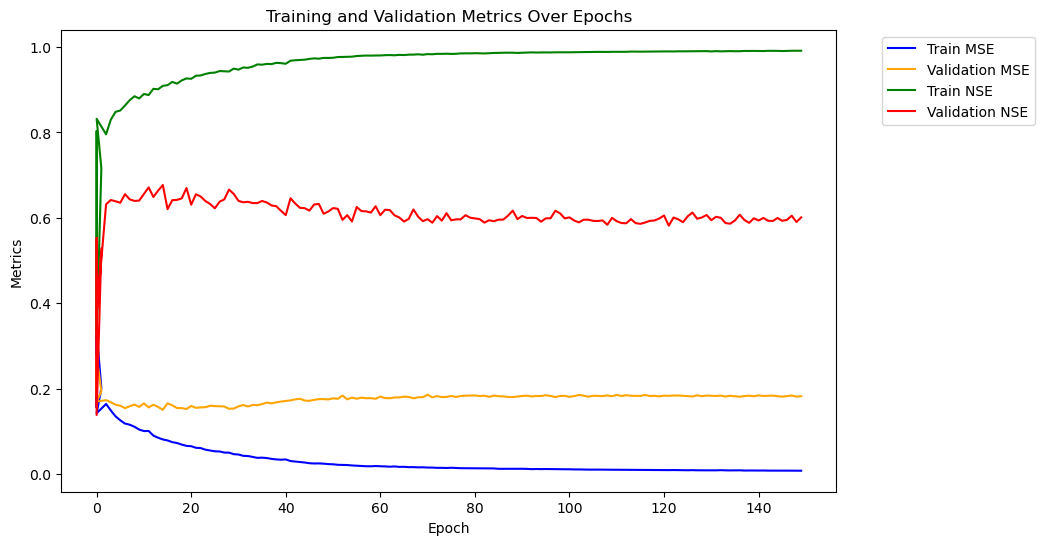

In [6]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train_mse'], label='Train MSE', color='blue')
plt.plot(df['epoch'], df['val_mse'], label='Validation MSE', color='orange')
plt.plot(df['epoch'], df['train_nse'], label='Train NSE', color='green')
plt.plot(df['epoch'], df['val_nse'], label='Validation NSE', color='red')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics Over Epochs')
plt.legend()

# Place the legend outside the plot area on the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# Show the plot
plt.show()

In [1]:
import optuna
import json
from optuna.visualization import plot_optimization_history

c:\Users\mkauzlaric\AppData\Local\anaconda3\envs\projectIIIgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os

# Get the current working directory
current_working_directory = os.getcwd()
print("Current working directory:", current_working_directory)

Current working directory: s:\tina\AML\P3


In [7]:
# Define the directory where the study and JSON file are located
study_directory = "S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs512_lr0.001_wd0.01_warm_up@seed12"

# Provide the correct directory path to the JSON file
json_file_path = os.path.join(study_directory, "best_hyperparams.json")

# Load the best hyperparameters from the JSON file
with open(json_file_path, "r") as f:
    best_hyperparams = json.load(f)

# Now you can use the study and the best hyperparameters
print("Best hyperparameters:", best_hyperparams)

Best hyperparameters: {'learning_rate': 0.0001, 'batch_size': 128, 'weight_dr': 0.01}


In [8]:
# Define the directory where the study and JSON file are located
study_directory = "S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs512_lr0.001_wd0.01_warm_up@seed12"

# Check if the database file exists
db_path = os.path.join(study_directory, "LSTMMSVS2S_FirstOptimizationTrial.db")
if not os.path.exists(db_path):
    print(f"Database file does not exist at {db_path}")
else:
    print(f"Database file found at {db_path}")

# Load the study from the SQLite database
try:
    study = optuna.load_study(study_name="LSTMMSVS2S_FirstOptimizationTrial",
                              storage=f"sqlite:///{db_path}")
    print("Study loaded successfully")
except KeyError as e:
    print(f"Error loading study: {e}")

Database file found at S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs512_lr0.001_wd0.01_warm_up@seed12\LSTMMSVS2S_FirstOptimizationTrial.db
Error loading study: 'Record does not exist.'


In [1]:
import os
import optuna
import json
import nbformat
import plotly.io as pio
from optuna.visualization import plot_optimization_history

# Verify nbformat version
print(f"nbformat version: {nbformat.__version__}")

# Define the directory where the study and JSON file are located
study_directory = "S:/tina/AML/P3/RR-Former"

# Check if the database file exists
db_path = os.path.join(study_directory, "LSTMMSVS2S_FirstOptimizationTrial.db")
if not os.path.exists(db_path):
    print(f"Database file does not exist at {db_path}")
else:
    print(f"Database file found at {db_path}")

# List all studies in the SQLite database
storage_url = f"sqlite:///{db_path}"
study_summaries = optuna.study.get_all_study_summaries(storage=storage_url)
print("Available studies:")
for study_summary in study_summaries:
    print(f"Study name: {study_summary.study_name}")

# Load the study from the SQLite database
try:
    study = optuna.load_study(study_name="LSTMMSVS2S_FirstOptimizationTrial",
                              storage=storage_url)
    print("Study loaded successfully")
except KeyError as e:
    print(f"Error loading study: {e}")
    print("Please check the study name and ensure it matches one of the available studies listed above.")
    # Exit the script if the study cannot be loaded
    exit(1)

# Plot the optimization history
fig = plot_optimization_history(study)

# Explicitly check nbformat version before showing the plot
if nbformat and nbformat.__version__ >= "4.2.0":
    pio.show(fig)
else:
    raise ValueError("Mime type rendering requires nbformat>=4.2.0 but it is not installed")

c:\Users\mkauzlaric\AppData\Local\anaconda3\envs\projectIIIgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nbformat version: 5.9.2
Database file found at S:/tina/AML/P3/RR-Former\LSTMMSVS2S_FirstOptimizationTrial.db
Available studies:
Study name: LSTMMSVS2S_FirstOptimizationTrial
Study loaded successfully


In [3]:
from optuna.visualization import plot_param_importances
plot_param_importances(study).show()

In [7]:
import os
from datetime import datetime
import optuna

def get_folder_timestamps(root_directory):
    folder_timestamps = {}
    
    for folder_name in os.listdir(root_directory):
        folder_path = os.path.join(root_directory, folder_name)
        
        if os.path.isdir(folder_path):
            # Get the creation or modification timestamp
            timestamp = os.path.getmtime(folder_path)
            folder_timestamps[folder_name] = datetime.fromtimestamp(timestamp)
    
    return folder_timestamps

def get_trial_timestamps(study_name, storage):
    trial_timestamps = {}
    
    study = optuna.load_study(study_name=study_name, storage=storage)
    trials = study.trials
    
    for trial in trials:
        trial_id = trial.number
        timestamp = trial.datetime_start
        trial_timestamps[trial_id] = timestamp
    
    return trial_timestamps

def reconstruct_mapping(folder_timestamps, trial_timestamps):
    mapping = {}
    
    for folder_name, folder_timestamp in folder_timestamps.items():
        closest_trial_id = None
        closest_time_diff = None
        
        for trial_id, trial_timestamp in trial_timestamps.items():
            time_diff = abs((folder_timestamp - trial_timestamp).total_seconds())
            
            if closest_time_diff is None or time_diff < closest_time_diff:
                closest_time_diff = time_diff
                closest_trial_id = trial_id
        
        if closest_trial_id:
            mapping[closest_trial_id] = folder_name
    
    return mapping

# Example usage
root_directory = 'S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs512_lr0.001_wd0.01_warm_up@seed12'
study_name = 'LSTMMSVS2S_FirstOptimizationTrial'  # Replace with your actual study name
storage = 'sqlite:///S:/tina/AML/P3/RR-Former/LSTMMSVS2S_FirstOptimizationTrial.db'

folder_timestamps = get_folder_timestamps(root_directory)
trial_timestamps = get_trial_timestamps(study_name, storage)
mapping = reconstruct_mapping(folder_timestamps, trial_timestamps)

# Print the mapping
for trial_id, folder_name in mapping.items():
    print(f"Trial ID: {trial_id} -> Folder Name: {folder_name}")

Trial ID: 8 -> Folder Name: fold0_068
Trial ID: 21 -> Folder Name: fold0_08e
Trial ID: 7 -> Folder Name: fold0_1db
Trial ID: 15 -> Folder Name: fold0_2a9
Trial ID: 25 -> Folder Name: fold0_2c5
Trial ID: 17 -> Folder Name: fold0_2f9
Trial ID: 29 -> Folder Name: fold0_302
Trial ID: 16 -> Folder Name: fold0_39d
Trial ID: 27 -> Folder Name: fold0_3c5
Trial ID: 10 -> Folder Name: fold0_40d
Trial ID: 13 -> Folder Name: fold0_41b
Trial ID: 23 -> Folder Name: fold0_46b
Trial ID: 31 -> Folder Name: fold0_f56
Trial ID: 14 -> Folder Name: fold0_494
Trial ID: 20 -> Folder Name: fold0_574
Trial ID: 24 -> Folder Name: fold0_625
Trial ID: 12 -> Folder Name: fold0_71e
Trial ID: 30 -> Folder Name: fold0_896
Trial ID: 28 -> Folder Name: fold0_968
Trial ID: 11 -> Folder Name: fold0_a24
Trial ID: 9 -> Folder Name: fold0_a32
Trial ID: 26 -> Folder Name: fold0_af9
Trial ID: 22 -> Folder Name: fold0_b38
Trial ID: 19 -> Folder Name: fold0_b5f
Trial ID: 6 -> Folder Name: fold0_bac
Trial ID: 4 -> Folder Name: f

In [8]:
import os
from datetime import datetime
import optuna
import csv

def get_folder_timestamps(root_directory):
    folder_timestamps = {}
    
    for folder_name in os.listdir(root_directory):
        folder_path = os.path.join(root_directory, folder_name)
        
        if os.path.isdir(folder_path):
            # Get the creation or modification timestamp
            timestamp = os.path.getmtime(folder_path)
            folder_timestamps[folder_name] = datetime.fromtimestamp(timestamp)
    
    return folder_timestamps

def get_trial_timestamps(study_name, storage):
    trial_timestamps = {}
    
    study = optuna.load_study(study_name=study_name, storage=storage)
    trials = study.trials
    
    for trial in trials:
        trial_id = trial.number
        timestamp = trial.datetime_start
        trial_timestamps[trial_id] = timestamp
    
    return trial_timestamps

def reconstruct_mapping(folder_timestamps, study):
    mapping = []
    
    for folder_name, folder_timestamp in folder_timestamps.items():
        closest_trial = None
        closest_time_diff = None
        
        for trial in study.trials:
            trial_id = trial.number
            trial_timestamp = trial.datetime_start
            time_diff = abs((folder_timestamp - trial_timestamp).total_seconds())
            
            if closest_time_diff is None or time_diff < closest_time_diff:
                closest_time_diff = time_diff
                closest_trial = trial
        
        if closest_trial:
            mapping.append({
                'trial_id': closest_trial.number,
                'folder_name': folder_name,
                'params': closest_trial.params,
                'validation_loss': closest_trial.value
            })
    
    return mapping

def write_mapping_to_csv(mapping, output_file):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Trial ID', 'Folder Name', 'Parameters', 'Validation Loss'])
        
        for entry in mapping:
            writer.writerow([
                entry['trial_id'],
                entry['folder_name'],
                entry['params'],
                entry['validation_loss']
            ])

# Example usage
root_directory = 'S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs512_lr0.001_wd0.01_warm_up@seed12'
study_name = 'LSTMMSVS2S_FirstOptimizationTrial'  # Replace with your actual study name
storage = 'sqlite:///S:/tina/AML/P3/RR-Former/LSTMMSVS2S_FirstOptimizationTrial.db'
output_file = 'S:/tina/AML/P3/RR-Former/mapping_LSTMMSVS2S_FirstOptimizationTrial.csv'

folder_timestamps = get_folder_timestamps(root_directory)
study = optuna.load_study(study_name=study_name, storage=storage)
mapping = reconstruct_mapping(folder_timestamps, study)
write_mapping_to_csv(mapping, output_file)

print(f"Mapping written to {output_file}")

Mapping written to S:/tina/AML/P3/RR-Former/mapping_LSTMMSVS2S_FirstOptimizationTrial.csv


In [41]:
import os
import pandas as pd

def get_folder_timestamps(root_directory):
    folder_timestamps = {}
    
    for folder_name in os.listdir(root_directory):
        folder_path = os.path.join(root_directory, folder_name)
        
        if os.path.isdir(folder_path):
            # Get the creation or modification timestamp
            timestamp = os.path.getmtime(folder_path)
            folder_timestamps[folder_name] = datetime.fromtimestamp(timestamp)
    
    return folder_timestamps

def get_trial_timestamps(study_name, storage):
    trial_timestamps = {}
    
    study = optuna.load_study(study_name=study_name, storage=storage)
    trials = study.trials
    
    for trial in trials:
        trial_id = trial.number
        timestamp = trial.datetime_start
        trial_timestamps[trial_id] = timestamp
    
    return trial_timestamps

def get_val_mse_stats(folder_path):
    log_train_path = os.path.join(folder_path, 'log_train.csv')

    if os.path.exists(log_train_path):
        # Read the CSV file, skipping the first line and using the second line as the header
        df = pd.read_csv(log_train_path, skiprows=1)
        print(f"DataFrame:\n{df}")  # Debugging statement

        # Extract the val_mse column
        val_mse_values = df['val_mse'].dropna().astype(float).tolist()
        print(f"val_mse_values: {val_mse_values}")  # Debugging statement

        if val_mse_values:
            min_val_mse = min(val_mse_values)
            avg_last_25_val_mse = sum(val_mse_values[-25:]) / min(25, len(val_mse_values))
        else:
            min_val_mse = None
            avg_last_25_val_mse = None
    else:
        min_val_mse = None
        avg_last_25_val_mse = None

    return min_val_mse, avg_last_25_val_mse

def reconstruct_mapping(folder_timestamps, study, root_directory):
    mapping = []
    
    for folder_name, folder_timestamp in folder_timestamps.items():
        closest_trial = None
        closest_time_diff = None
        
        for trial in study.trials:
            trial_id = trial.number
            trial_timestamp = trial.datetime_start
            time_diff = abs((folder_timestamp - trial_timestamp).total_seconds())
            
            if closest_time_diff is None or time_diff < closest_time_diff:
                closest_time_diff = time_diff
                closest_trial = trial
        
        if closest_trial:
            folder_path = os.path.join(root_directory, folder_name)
            min_val_mse, avg_last_25_val_mse = get_val_mse_stats(folder_path)
            mapping.append({
                'trial_id': closest_trial.number,
                'folder_name': folder_name,
                'params': closest_trial.params,
                'validation_loss': closest_trial.value,
                'min_val_mse': min_val_mse,
                'avg_last_25_val_mse': avg_last_25_val_mse
            })
    
    return mapping

def add_ranks(mapping):
    # Sort and rank by validation_loss
    mapping.sort(key=lambda x: x['validation_loss'])
    for rank, entry in enumerate(mapping, start=1):
        entry['validation_loss_rank'] = rank

    # Sort and rank by min_val_mse
    mapping.sort(key=lambda x: (x['min_val_mse'] is None, x['min_val_mse']))
    for rank, entry in enumerate(mapping, start=1):
        entry['min_val_mse_rank'] = rank

    # Sort and rank by avg_last_25_val_mse
    mapping.sort(key=lambda x: (x['avg_last_25_val_mse'] is None, x['avg_last_25_val_mse']))
    for rank, entry in enumerate(mapping, start=1):
        entry['avg_last_25_val_mse_rank'] = rank

    return mapping

def write_mapping_to_csv(mapping, output_file):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            'Trial ID', 'Folder Name', 'Parameters', 'Validation Loss', 
            'Min Val MSE', 'Avg Last 25 Val MSE', 
            'Validation Loss Rank', 'Min Val MSE Rank', 'Avg Last 25 Val MSE Rank'
        ])
        
        for entry in mapping:
            writer.writerow([
                entry['trial_id'],
                entry['folder_name'],
                entry['params'],
                entry['validation_loss'],
                entry['min_val_mse'],
                entry['avg_last_25_val_mse'],
                entry['validation_loss_rank'],
                entry['min_val_mse_rank'],
                entry['avg_last_25_val_mse_rank']
            ])

# Example usage
root_directory = 'S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs512_lr0.001_wd0.01_warm_up@seed12'
study_name = 'LSTMMSVS2S_FirstOptimizationTrial'  # Replace with your actual study name
storage = 'sqlite:///S:/tina/AML/P3/RR-Former/LSTMMSVS2S_FirstOptimizationTrial.db'
output_file = 'S:/tina/AML/P3/RR-Former/mapping_LSTMMSVS2S_FirstOptimizationTrial.csv'

folder_timestamps = get_folder_timestamps(root_directory)
study = optuna.load_study(study_name=study_name, storage=storage)
mapping = reconstruct_mapping(folder_timestamps, study, root_directory)
mapping = add_ranks(mapping)
write_mapping_to_csv(mapping, output_file)

print(f"Mapping written to {output_file}")

DataFrame:
    epoch  train_loss_iterated  train_mse   val_mse  train_nse    val_nse
0       0             0.072189   0.838271  0.598957 -33.095497 -74.354622
1       1             0.033804   0.474081  0.360813  -0.652554  -1.049902
2       2             0.022383   0.340457  0.274928   0.288220   0.093344
3       3             0.016822   0.261931  0.222684   0.570370   0.347002
4       4             0.013900   0.223117  0.198301   0.674111   0.465744
..    ...                  ...        ...       ...        ...        ...
67     67             0.003402   0.063237  0.163799   0.927171   0.509206
68     68             0.003381   0.062599  0.163152   0.928647   0.527176
69     69             0.003355   0.062358  0.163341   0.928617   0.526186
70     70             0.003327   0.062255  0.165118   0.927239   0.517905
71     71             0.003310   0.061212  0.163163   0.930937   0.523578

[72 rows x 6 columns]
val_mse_values: [0.598956572291526, 0.360812899085947, 0.2749283923403443, 0.2

Check that something was written in the y_stds_dict

In [1]:
import json
import os

# Define the path to the JSON file
json_file_path = 'S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12/fine_tune/2009/y_stds_dict.json'

# Check if the file exists
if not os.path.exists(json_file_path):
    print(f"File not found: {json_file_path}")
else:
    # Open and load the JSON file
    with open(json_file_path, 'r') as file:
        y_stds_dict = json.load(file)
    
    # Print the contents of the JSON file
    print(json.dumps(y_stds_dict, indent=4))

{
    "2009": 1.6851286888122559
}


Write out test results for all basins per fold

In [165]:
import os
import pandas as pd

# Define the working directory (change this to your actual working directory)
wd = "S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12"
metrics_dir = os.path.join(wd, "metrics")
os.makedirs(metrics_dir, exist_ok=True)

# Define the metrics you want to extract
metrics = [
    "mse",
    "rmse",
    "bias",
    "nse",
    "kge",
    "kgenp",
    "atpe",
    "biasfms"
]

# Loop through each fold directory
nr_folds = 5
for fold in range(nr_folds):
    fold_dir = os.path.join(wd, f"fold{fold}", "pretrain_test_single_ext")
    
    # Prepare a dictionary to hold dataframes for each metric
    metric_data = {metric: [] for metric in metrics}
    
    # Loop through each basinID directory
    for basin_id in os.listdir(fold_dir):
        basin_dir = os.path.join(fold_dir, basin_id)
        log_file = os.path.join(basin_dir, "log_test.csv")
        
        if not os.path.exists(log_file):
            continue
        
        # Read the log_test.csv file and skip the header
        with open(log_file, "r") as file:
            lines = file.readlines()[1:]  # parameters count is in the first line, skip it
        # Process each metric
        j=0
        for i in range(0, len(metrics*3), 3): 
            mean_metric = metrics[j]
            #lead_time_metric = metrics[j + 1]
            #j=j+2
            j=j+1

            # Extract mean value
            mean_value = float(lines[i].split(":")[1].strip())

            # Extract per-lead-time values (skip the next line)
            values = [float(val) for val in lines[i + 2].strip().split(',')]
    
            # Append data to the respective metric list
            metric_data[mean_metric].append([basin_id] + values + [mean_value])
    
    # Write the results to text files
    for metric, data in metric_data.items():
        df = pd.DataFrame(data, columns=["basin_id"] + [f"{metric}{i+1}" for i in range(7)] + [f"{metric}_mean"])
        output_file = os.path.join(metrics_dir, f"fold{fold}_{metric}.txt")
        df.to_csv(output_file, index=False, sep="\t")
        print(f"Saved {output_file}")

Saved S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12\metrics\fold0_mse.txt
Saved S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12\metrics\fold0_rmse.txt
Saved S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12\metrics\fold0_bias.txt
Saved S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12\metrics\fold0_nse.txt
Saved S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[2

Visualize the data per fold:

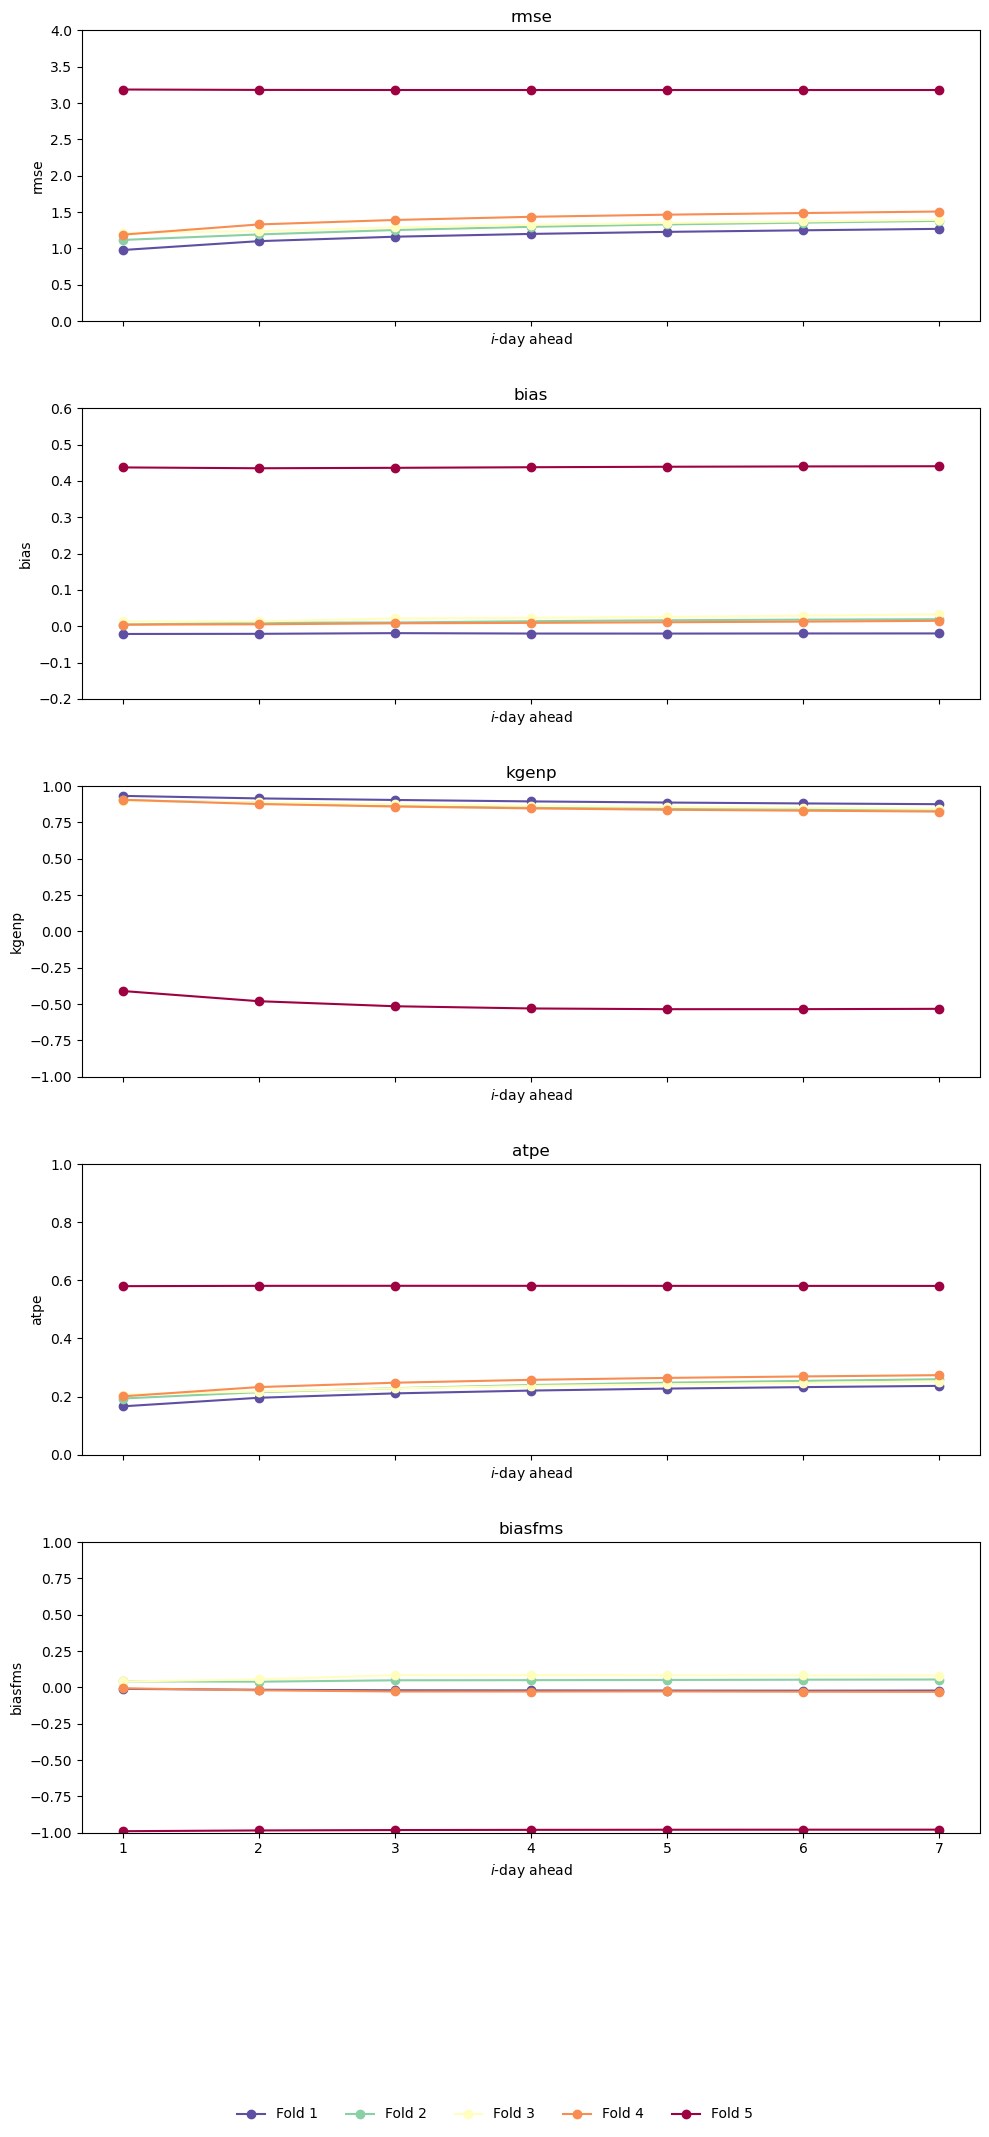

In [186]:
# Define the metrics and number of folds
metrics = [
    "rmse", "bias", "kgenp", "atpe", "biasfms"
]
nr_folds = 5
days_ahead = 7

# Define y-axis limits for each metric
y_limits = {
    "rmse": (0, 4),
    "bias": (-0.2, 0.6),
    "kgenp": (-1, 1),
    "atpe": (0, 1),
    "biasfms": (-1, 1)
}

# Initialize a dictionary to store the data
metric_data = {metric: [] for metric in metrics}

# Read the data from the text files
for fold in range(nr_folds):
    for metric in metrics:
        file_path = os.path.join(metrics_dir, f"fold{fold}_{metric}.txt")
        df = pd.read_csv(file_path, sep="\t")
        metric_data[metric].append(df)

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 20), sharex=True)

# Define colors for each fold using the tab20 colormap
colors = plt.cm.Spectral_r(np.linspace(0, 1, nr_folds))

# Plot data
for i, metric in enumerate(metrics):
    ax = axes[i]
    for j in range(nr_folds):
        df = metric_data[metric][j]
        mean_values = df[[f"{metric}{k+1}" for k in range(days_ahead)]].mean(axis=0)
        ax.plot(range(1, days_ahead + 1), mean_values, marker='o', color=colors[j], label=f'Fold {j + 1}')
    
    ax.set_ylabel(metric)
    ax.set_xticks(range(1, days_ahead + 1))
    ax.set_xlabel(r'$\it{i}$-day ahead')
    ax.set_title(f'{metric}')
    
    # Set y-axis limits based on the metric
    if y_limits[metric] is not None:
        ax.set_ylim(y_limits[metric])

# Add a single legend for the entire figure
fig.legend(labels=[f'Fold {i + 1}' for i in range(nr_folds)], loc='upper center', ncol=nr_folds, bbox_to_anchor=(0.5, -0.1), frameon=False, bbox_transform=fig.transFigure)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.3)

# Save the figure to a PDF file in A4 format
output_file = os.path.join("S:/tina/AML/P3/", 'metrics_fold01234.pdf')
plt.savefig(output_file, format='pdf', bbox_inches='tight')
plt.show()

In [280]:
# Define the working directory (change this to your actual working directory)
wd = "S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12"
metrics_dir = os.path.join(wd, "metrics")

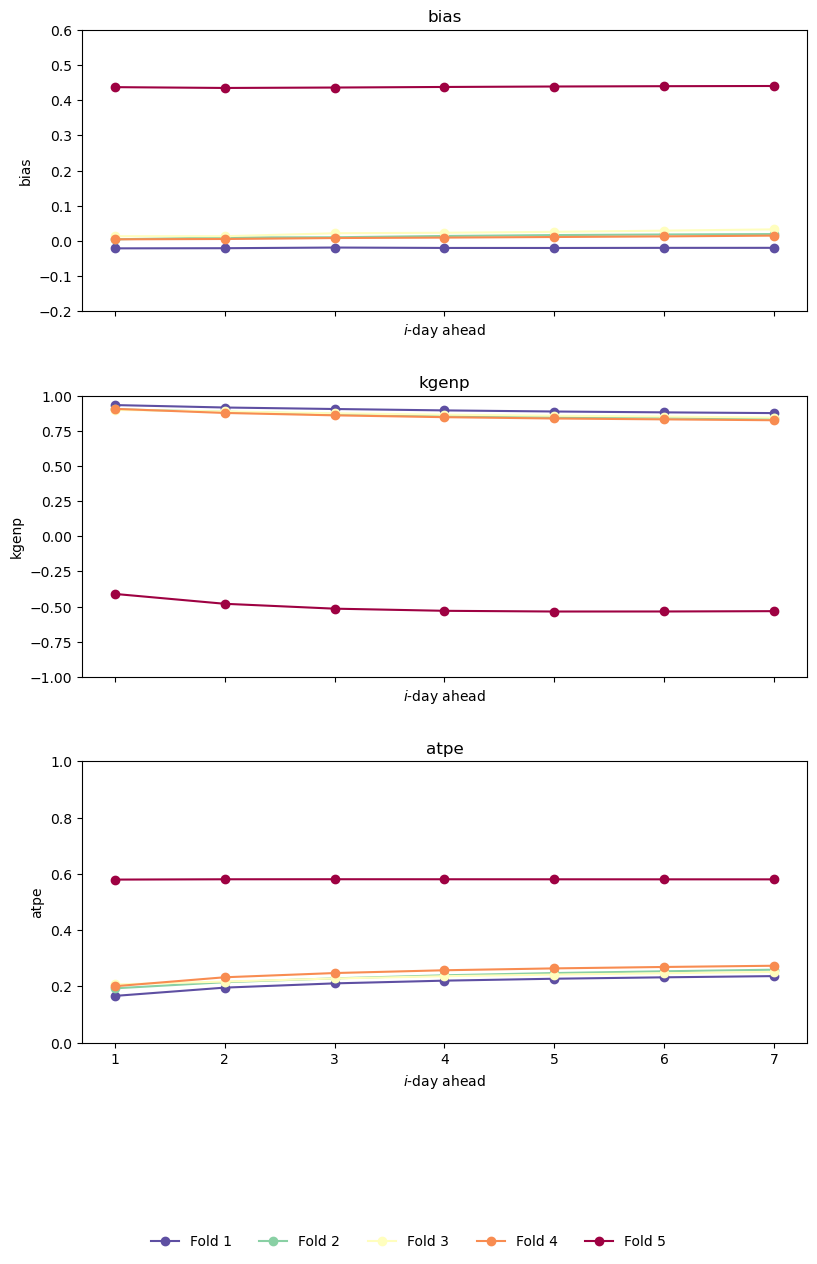

In [285]:
# Define the metrics and number of folds
metrics = [
     "bias", "kgenp", "atpe"
]
nr_folds = 5
days_ahead = 7

# Define y-axis limits for each metric
y_limits = {
    "rmse": (0, 4),
    "bias": (-0.2, 0.6),
    "kgenp": (-1, 1),
    "atpe": (0, 1),
    "biasfms": (-1, 1)
}

# Initialize a dictionary to store the data
metric_data = {metric: [] for metric in metrics}

# Read the data from the text files
for fold in range(nr_folds):
    for metric in metrics:
        file_path = os.path.join(metrics_dir, f"fold{fold}_{metric}.txt")
        df = pd.read_csv(file_path, sep="\t")
        metric_data[metric].append(df)

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8.27, 11.69), sharex=True)

# Define colors for each fold using the tab20 colormap
colors = plt.cm.Spectral_r(np.linspace(0, 1, nr_folds))

# Plot data
for i, metric in enumerate(metrics):
    ax = axes[i]
    for j in range(nr_folds):
        df = metric_data[metric][j]
        mean_values = df[[f"{metric}{k+1}" for k in range(days_ahead)]].mean(axis=0)
        ax.plot(range(1, days_ahead + 1), mean_values, marker='o', color=colors[j], label=f'Fold {j + 1}')
    
    ax.set_ylabel(metric)
    ax.set_xticks(range(1, days_ahead + 1))
    ax.set_xlabel(r'$\it{i}$-day ahead')
    ax.set_title(f'{metric}')
    
    # Set y-axis limits based on the metric
    if y_limits[metric] is not None:
        ax.set_ylim(y_limits[metric])

# Add a single legend for the entire figure
fig.legend(labels=[f'Fold {i + 1}' for i in range(nr_folds)], loc='upper center', ncol=nr_folds, bbox_to_anchor=(0.5, -0.1), frameon=False, bbox_transform=fig.transFigure)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.3)

# Save the figure to a PDF file in A4 format
output_file = os.path.join("S:/tina/AML/P3/", 'metrix_fold01234.pdf')
plt.savefig(output_file, format='pdf', bbox_inches='tight')
plt.show()

Remove fold 4, which is completely out of the place:

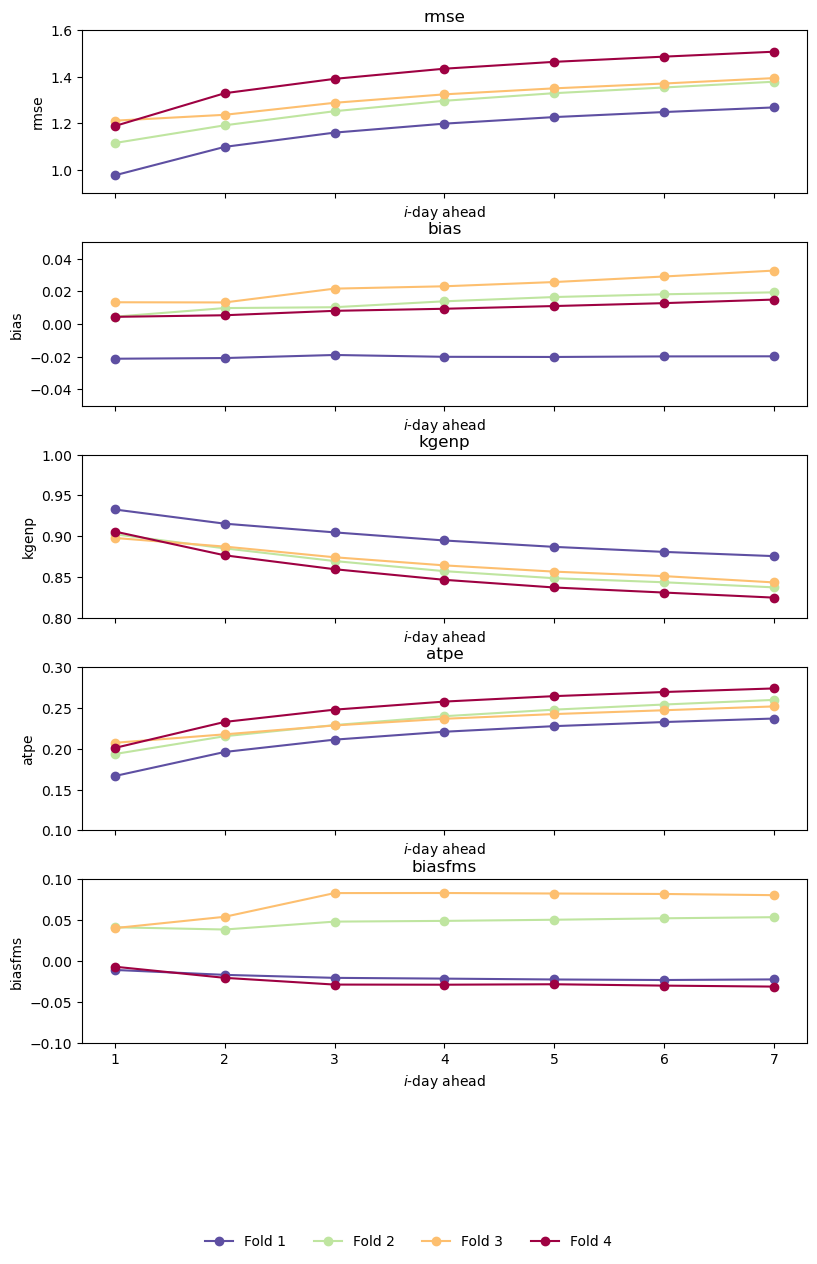

In [286]:
# Define the metrics and number of folds
metrics = [
    "rmse", "bias", "kgenp", "atpe", "biasfms"
]
nr_folds = 4
days_ahead = 7

# Define y-axis limits for each metric
y_limits = {
    "rmse": (0.9, 1.6),
    "bias": (-.05, 0.05),
    "kgenp": (0.8, 1),
    "atpe": (0.1, 0.3),
    "biasfms": (-0.1, 0.1)
}

# Initialize a dictionary to store the data
metric_data = {metric: [] for metric in metrics}

# Read the data from the text files
for fold in range(nr_folds):
    for metric in metrics:
        file_path = os.path.join(metrics_dir, f"fold{fold}_{metric}.txt")
        df = pd.read_csv(file_path, sep="\t")
        metric_data[metric].append(df)

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8.27, 11.69), sharex=True)

# Define colors for each fold
colors = plt.cm.Spectral_r(np.linspace(0, 1, nr_folds))

# Plot data
for i, metric in enumerate(metrics):
    ax = axes[i]
    for j in range(nr_folds):
        df = metric_data[metric][j]
        mean_values = df[[f"{metric}{k+1}" for k in range(days_ahead)]].mean(axis=0)
        ax.plot(range(1, days_ahead + 1), mean_values, marker='o', color=colors[j], label=f'Fold {j + 1}')
    
    ax.set_ylabel(metric)
    ax.set_xticks(range(1, days_ahead + 1))
    ax.set_xlabel(r'$\it{i}$-day ahead')
    ax.set_title(f'{metric}')
    
    # Set y-axis limits based on the metric
    if y_limits[metric] is not None:
        ax.set_ylim(y_limits[metric])

# Add a single legend for the entire figure
fig.legend(labels=[f'Fold {i + 1}' for i in range(nr_folds)], loc='upper center', ncol=nr_folds, bbox_to_anchor=(0.5, -0.1), frameon=False, bbox_transform=fig.transFigure)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.3)

# Save the figure to a PDF file in A4 format
output_file = os.path.join("S:/tina/AML/P3/", 'metrix_fold0123.pdf')
plt.savefig(output_file, format='pdf', bbox_inches='tight')

# Show the figure
plt.show()

I hate the legend..I cannot figure out how to change the spacing :-/

Let us have a look at the difference in performance between LSTM and Transformer

First extract again the performance metrics for all basins:

In [218]:
wd = "S:/tina/AML/RR-Former/runs" #TODO change the directory if needed
#CAMELS-CH: "S:/tina/AML/P3/RR-Former_v1/runs"; CAMELS-USA: "S:/tina/AML/RR-Former/runs"
runs = os.listdir(wd)
print(runs)

['LSTMMSVS2S_[[22-7-32-128][15-%-1-128][%-7-256-128]-0.2]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone', 'Transformer_NAR_[64-4-4-256-0.1]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone']


Define runs' names

In [219]:
runs_nms = [
    "LSTMMSVS2S",
    "Transformer_NAR"
]

In [220]:
# Loop through each run
for run_nm in range(len(runs_nms)):

    # Check which runs_nm is in which runs
    match_run_nm = [run for run in runs if runs_nms[run_nm] in run]
    print(match_run_nm)
    test_dir = os.path.join(wd, match_run_nm[0], "pretrain_test_single_ext")
    print(test_dir)

['LSTMMSVS2S_[[22-7-32-128][15-%-1-128][%-7-256-128]-0.2]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone']
S:/tina/AML/RR-Former/runs\LSTMMSVS2S_[[22-7-32-128][15-%-1-128][%-7-256-128]-0.2]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone\pretrain_test_single_ext
['Transformer_NAR_[64-4-4-256-0.1]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone']
S:/tina/AML/RR-Former/runs\Transformer_NAR_[64-4-4-256-0.1]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone\pretrain_test_single_ext


In [221]:
# Define the metrics you want to extract
metrics = [
    "mse",
    "rmse",
    "bias",
    "nse",
    "kge",
    "kgenp",
    "atpe",
    "biasfms"
]

# Loop through each run
for run_nm in range(len(runs_nms)):

    # Check which runs_nm is in which runs
    match_run_nm = [run for run in runs if runs_nms[run_nm] in run]
    print(match_run_nm)
    # Make a directory to store the metrics
    metrics_dir = os.path.join(wd, match_run_nm[0],"metrics")
    os.makedirs(metrics_dir, exist_ok=True)
    # Define the directory where the test logs are located
    test_dir = os.path.join(wd, match_run_nm[0], "pretrain_test_single_ext")
    
    # Prepare a dictionary to hold dataframes for each metric
    metric_data = {metric: [] for metric in metrics}
    
    # Loop through each basinID directory
    for basin_id in os.listdir(test_dir):
        basin_dir = os.path.join(test_dir, basin_id)
        log_file = os.path.join(basin_dir, "log_test.csv")
        
        if not os.path.exists(log_file):
            continue
        
        # Read the log_test.csv file and skip the header
        with open(log_file, "r") as file:
            lines = file.readlines()[1:]  # parameters count is in the first line, skip it
        # Process each metric
        j = 0
        for i in range(0, len(metrics) * 3, 3): 
            mean_metric = metrics[j]
            j += 1

            # Extract mean value
            mean_value = float(lines[i].split(":")[1].strip())

            # Extract per-lead-time values (skip the next line)
            values = [float(val) for val in lines[i + 2].strip().split(',')]
    
            # Append data to the respective metric list
            metric_data[mean_metric].append([basin_id] + values + [mean_value])
    
    # Write the results to text files
    for metric, data in metric_data.items():
        df = pd.DataFrame(data, columns=["basin_id"] + [f"{metric}{i+1}" for i in range(days_ahead)] + [f"{metric}_mean"])
        output_file = os.path.join(metrics_dir, f"{runs_nms[run_nm]}_{metric}.txt")
        df.to_csv(output_file, index=False, sep="\t")
        print(f"Saved {output_file}")

['LSTMMSVS2S_[[22-7-32-128][15-%-1-128][%-7-256-128]-0.2]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone']
Saved S:/tina/AML/RR-Former/runs\LSTMMSVS2S_[[22-7-32-128][15-%-1-128][%-7-256-128]-0.2]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone\metrics\LSTMMSVS2S_mse.txt
Saved S:/tina/AML/RR-Former/runs\LSTMMSVS2S_[[22-7-32-128][15-%-1-128][%-7-256-128]-0.2]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone\metrics\LSTMMSVS2S_rmse.txt
Saved S:/tina/AML/RR-Former/runs\LSTMMSVS2S_[[22-7-32-128][15-%-1-128][%-7-256-128]-0.2]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone\metrics\LSTMMSVS2S_bias.txt
Saved S:/tina/AML/RR-Former/runs\LSTMMSVS2S_[[22-7-32-128][15-%-1-128][%-7-256-128]-0.2]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone\metrics\LST

Now plot the CDFs of some metrics for all lead times

In [239]:
wd = "S:/tina/AML/P3/RR-Former_v1/runs" #TODO change the directory if needed
#CAMELS-CH: "S:/tina/AML/P3/RR-Former_v1/runs"; CAMELS-USA: "S:/tina/AML/RR-Former/runs"
runs = os.listdir(wd)
print(runs)

['LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet168_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone', 'Transformer_NAR_[64-4-4-256-0.1]@daymet168_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone']


In [225]:
metrics_dir

'S:/tina/AML/RR-Former/runs\\LSTMMSVS2S_[[22-7-32-128][15-%-1-128][%-7-256-128]-0.2]@daymet431_1980~1995#1995~2000#2000~2014@22_15+7[32+1]@NSELoss_n150_bs512_lr0.001_warm_up@seedNone\\metrics'

In [240]:
# Function to compute CDF
def compute_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Define the metrics you want to extract
metrics = [
    "mse",
    "rmse",
    "bias",
    "nse",
    "kge",
    "kgenp",
    "atpe",
    "biasfms"
]


    
# Load data for both models
transformer_data = pd.DataFrame()
lstm_data = pd.DataFrame()
    
for metric in metrics:
    
    transformer_file = os.path.join(wd, runs[1],"metrics", f"Transformer_NAR_{metric}.txt")
    lstm_file = os.path.join(wd, runs[0],"metrics", f"LSTMMSVS2S_{metric}.txt")
    transformer_data = pd.read_csv(transformer_file, sep="\t")
    lstm_data = pd.read_csv(lstm_file, sep="\t")
    
    # Create subplots
    fig, axes = plt.subplots(4, 2, figsize=(8.27, 11.69))  # A4 size in inches
    axes = axes.flatten()
    
    # Plot CDFs for each metric and the mean
    for i in range(0, days_ahead + 1):
          
        if i < days_ahead:
            metric_name = f"{metric}{i+1}"
            panel_name = f"{i+1}st-day-ahead" if i == 0 else f"{i+1}nd-day-ahead" if i == 1 else f"{i+1}rd-day-ahead" if i == 2 else f"{i+1}th-day-ahead"
        else:
            metric_name = f"{metric}_mean"
            panel_name = "mean"
        
        # Compute CDF for Transformer
        transformer_sorted, transformer_cdf = compute_cdf(transformer_data.iloc[:, i+1])
        
        # Compute CDF for LSTM
        lstm_sorted, lstm_cdf = compute_cdf(lstm_data.iloc[:, i+1])
        
        # Plot CDFs
        axes[i].plot(transformer_sorted, transformer_cdf, label='Transformer', color='blue')
        axes[i].plot(lstm_sorted, lstm_cdf, label='LSTM', color='red')
        
        # Set title and labels
        axes[i].set_title(f'{panel_name}')
        axes[i].set_xlabel(metric_name)
        axes[i].set_ylabel('CDF')
    
    # Adjust layout and add legend at the bottom
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    fig.legend(['Transformer', 'LSTM'], loc='lower center', ncol=2)
    
    # Save plot as A4 PDF
    output_pdf = os.path.join(wd, f"{metric}_CDF_plots.pdf")
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight')
    plt.close(fig)

In [ ]:
import os
import pandas as pd

# Define the working directory (change this to your actual working directory)
wd = "S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12"
metrics_dir = os.path.join(wd, "metrics")
os.makedirs(metrics_dir, exist_ok=True)

# Define the metrics you want to extract
metrics = [
    "mse",
    "rmse",
    "bias",
    "nse",
    "kge",
    "kgenp",
    "atpe",
    "biasfms"
]

# Loop through each fold directory
nr_folds = 5
for fold in range(nr_folds):
    fold_dir = os.path.join(wd, f"fold{fold}", "pretrain_test_single_ext")
    
    # Prepare a dictionary to hold dataframes for each metric
    metric_data = {metric: [] for metric in metrics}
    
    # Loop through each basinID directory
    for basin_id in os.listdir(fold_dir):
        basin_dir = os.path.join(fold_dir, basin_id)
        log_file = os.path.join(basin_dir, "log_test.csv")
        
        if not os.path.exists(log_file):
            continue
        
        # Read the log_test.csv file and skip the header
        with open(log_file, "r") as file:
            lines = file.readlines()[1:]  # parameters count is in the first line, skip it
        # Process each metric
        j=0
        for i in range(0, len(metrics*3), 3): 
            mean_metric = metrics[j]
            #lead_time_metric = metrics[j + 1]
            #j=j+2
            j=j+1

            # Extract mean value
            mean_value = float(lines[i].split(":")[1].strip())

            # Extract per-lead-time values (skip the next line)
            values = [float(val) for val in lines[i + 2].strip().split(',')]
    
            # Append data to the respective metric list
            metric_data[mean_metric].append([basin_id] + values + [mean_value])
    
    # Write the results to text files
    for metric, data in metric_data.items():
        df = pd.DataFrame(data, columns=["basin_id"] + [f"{metric}{i+1}" for i in range(7)] + [f"{metric}_mean"])
        output_file = os.path.join(metrics_dir, f"fold{fold}_{metric}.txt")
        df.to_csv(output_file, index=False, sep="\t")
        print(f"Saved {output_file}")

Saved S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12\metrics\fold0_mse.txt
Saved S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12\metrics\fold0_rmse.txt
Saved S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12\metrics\fold0_bias.txt
Saved S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[22-7-33-128][15-%-1-128][%-7-256-128]-0.2]@daymet218#kfold_strat_5folds_1980~1995#1995~2000#2000~2014@22_15+7[33+1]@NSELoss_n100_bs128_lr0.0001_wd0.01_warm_up@seed12\metrics\fold0_nse.txt
Saved S:/tina/AML/P3/RR-Former/runs/LSTMMSVS2S_[[2

How to look/call optuna optimization results and call these to visualize them on optuna-dashboard?

Steps in Detail:
1) Activate the Environment:
conda activate projectIIIgpu
2) Navigate to the Directory:
cd S:/tina/AML/P3/RR-Former
3) Run the Optuna Dashboard:
optuna-dashboard sqlite:///LSTMMSVS2S_FirstOptimizationTrial.db
4) Access the Dashboard: Open a web browser and go to the URL provided by the optuna-dashboard command,
 typically http://127.0.0.1:8080.